<a href="https://colab.research.google.com/github/AndrewBliss4/CS4442/blob/main/4442_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Predicting Toronto Traffic Flow
## <center>CS 4442 - Final Project
### <center>
### <center>Andrew Bliss, Abeer Muhammad

The following is the code which will take historic data at a given intersection and use it to predict traffic flow volumes at any given time:

In [119]:
# ==================================================
# ENVIRONMENT SETUP & GOOGLE DRIVE INTEGRATION
# ==================================================
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    print("Note: Running outside Google Colab - ensure data files are locally accessible")

# ==================================================
# LIBRARY IMPORTS (Organized by functionality)
# ==================================================

# --------------------------
# Standard Python Libraries
# --------------------------
import os
import sys
from pathlib import Path  # Better path handling

# --------------------------
# Core Data Science Stack
# --------------------------
import numpy as np  # Numerical computing (v1.23.5)
import pandas as pd  # Data manipulation (v1.5.3)

# --------------------------
# Data Visualization
# --------------------------
import matplotlib.pyplot as plt  # Basic plotting (v3.6.2)
import seaborn as sns  # Statistical visualization (v0.12.1)
plt.style.use('seaborn-v0_8-whitegrid')  # Consistent style

# --------------------------
# Data Preprocessing
# --------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --------------------------
# Model Evaluation
# --------------------------
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# --------------------------
# Machine Learning Models
# --------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# --------------------------
# Time Series Analysis
# --------------------------
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller  # For stationarity tests

# --------------------------
# Deep Learning (TensorFlow/Keras)
# --------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    Conv1D,
    Flatten,
    LSTM,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import dates as mdates
# --------------------------
# Utility & Configuration
# --------------------------
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configure pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Print library versions for debugging
print(f"TensorFlow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow Version: 2.18.0
Pandas Version: 2.2.2
NumPy Version: 2.0.2


## Random Forest Implementation

In [120]:
# =============================================
# DATA LOADING & INITIAL PROCESSING
# =============================================

def load_traffic_data(filepath):
    """Load and initially filter Toronto traffic data."""
    df = pd.read_csv('/content/drive/MyDrive/AI2/Final/tf-ft-eng.csv')
    return df[df['traffic_source'] == 'Toronto']

# Constants for street configurations
TORONTO_STREETS = {
    'ADELAIDE': 'ADELAIDE',
    'PARLIAMENT': 'PARLIAMENT'
}

# =============================================
# DATA PROCESSING PIPELINE
# =============================================

def preprocess_traffic_data(df, street_filter):
    """
    Process traffic data for a specific street or intersection.

    Args:
        df: Raw traffic DataFrame
        street_filter: String pattern to filter specific street(s)

    Returns:
        Processed DataFrame with datetime index and cleaned traffic counts
    """
    # Filter for specific street pattern
    filtered_df = filter_street_data(df, street_filter)

    # Clean and transform the data
    cleaned_df = (
        filtered_df
        .pipe(remove_rows_with_excessive_missing_values)
        .pipe(remove_outliers)
        .pipe(extract_traffic_time_series)
        .pipe(add_temporal_features)
        .pipe(clean_zero_traffic)
    )

    return cleaned_df

# =============================================
# PROCESSING HELPER FUNCTIONS
# =============================================

def filter_street_data(df, street_pattern):
    """Filter DataFrame for rows matching street pattern."""
    return df[df['camera_road'].str.contains(street_pattern, case=False, na=False)]

def remove_rows_with_excessive_missing_values(df, threshold=0.6):
    """Remove rows with more than threshold% missing values in date columns."""
    date_cols = [col for col in df.columns if col.startswith('x')]
    missing_pct = df[date_cols].isnull().sum(axis=1) / len(date_cols)
    return df[missing_pct < threshold].copy()

def remove_outliers(df):
    """Remove outlier traffic counts using IQR method."""
    date_cols = [col for col in df.columns if col.startswith('x')]

    # Calculate IQR bounds on stacked date columns
    stacked_values = df[date_cols].stack()
    Q1, Q3 = stacked_values.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter rows keeping those with at least one value within bounds
    return df[
        (df[date_cols] >= lower_bound).any(axis=1) &
        (df[date_cols] <= upper_bound).any(axis=1)
    ].copy()

def extract_traffic_time_series(df):
    """Extract and transform date columns into time series format."""
    date_cols = [col for col in df.columns if col.startswith('x')]

    # Sum traffic counts across all cameras for each date
    traffic_series = pd.DataFrame({
        'date': [col[1:] for col in date_cols],  # Remove 'x' prefix
        'traffic_count': df[date_cols].sum(axis=0)
    })

    # Convert to datetime and impute missing values
    traffic_series['date'] = pd.to_datetime(traffic_series['date'], format='%Y_%m_%d')
    traffic_series['traffic_count'] = SimpleImputer(strategy='mean').fit_transform(
        traffic_series[['traffic_count']]
    )

    return traffic_series

def add_temporal_features(df):
    """Add temporal features to the time series data."""
    return df.assign(
        day_of_week=df['date'].dt.dayofweek,
        month=df['date'].dt.month,
        day_of_month=df['date'].dt.day
    ).set_index('date')

def clean_zero_traffic(df):
    """Remove rows with zero traffic counts."""
    return df[df['traffic_count'] > 0]

# =============================================
# DATA PROCESSING EXECUTION
# =============================================

# Load and process data
traffic_df = load_traffic_data('/content/drive/MyDrive/AI2/Final/tf-ft-eng.csv')
rf_results = {}
# Process individual streets
adelaide_data = preprocess_traffic_data(traffic_df, TORONTO_STREETS['ADELAIDE'])
parliament_data = preprocess_traffic_data(traffic_df, TORONTO_STREETS['PARLIAMENT'])

# Process intersection (using regex pattern)
intersection_pattern = f"{TORONTO_STREETS['ADELAIDE']}.*{TORONTO_STREETS['PARLIAMENT']}|{TORONTO_STREETS['PARLIAMENT']}.*{TORONTO_STREETS['ADELAIDE']}"
intersection_data = preprocess_traffic_data(traffic_df, intersection_pattern)

# =============================================
# DATA INSPECTION
# =============================================

def display_data_summary(name, data):
    """Display summary of processed traffic data."""
    print(f"\n{name} Traffic Data")
    print(f"Time Range: {data.index.min()} to {data.index.max()}")
    print(f"Total Records: {len(data)}")
    print(f"Average Daily Traffic: {data['traffic_count'].mean():.1f}")
    print("\nSample Data:")
    print(data.head(3))

display_data_summary("Adelaide Street", adelaide_data)
display_data_summary("Parliament Street", parliament_data)
display_data_summary("Adelaide-Parliament Intersection", intersection_data)


Adelaide Street Traffic Data
Time Range: 2022-02-03 00:00:00 to 2024-12-28 00:00:00
Total Records: 976
Average Daily Traffic: 1875.3

Sample Data:
            traffic_count  day_of_week  month  day_of_month
date                                                       
2022-02-03       538.0000            3      2             3
2022-02-04       867.0000            4      2             4
2022-02-05       565.0000            5      2             5

Parliament Street Traffic Data
Time Range: 2022-02-03 00:00:00 to 2024-12-28 00:00:00
Total Records: 976
Average Daily Traffic: 3095.8

Sample Data:
            traffic_count  day_of_week  month  day_of_month
date                                                       
2022-02-03       884.0000            3      2             3
2022-02-04      1578.0000            4      2             4
2022-02-05       856.0000            5      2             5

Adelaide-Parliament Intersection Traffic Data
Time Range: 2022-02-03 00:00:00 to 2024-12-28 00:00:00


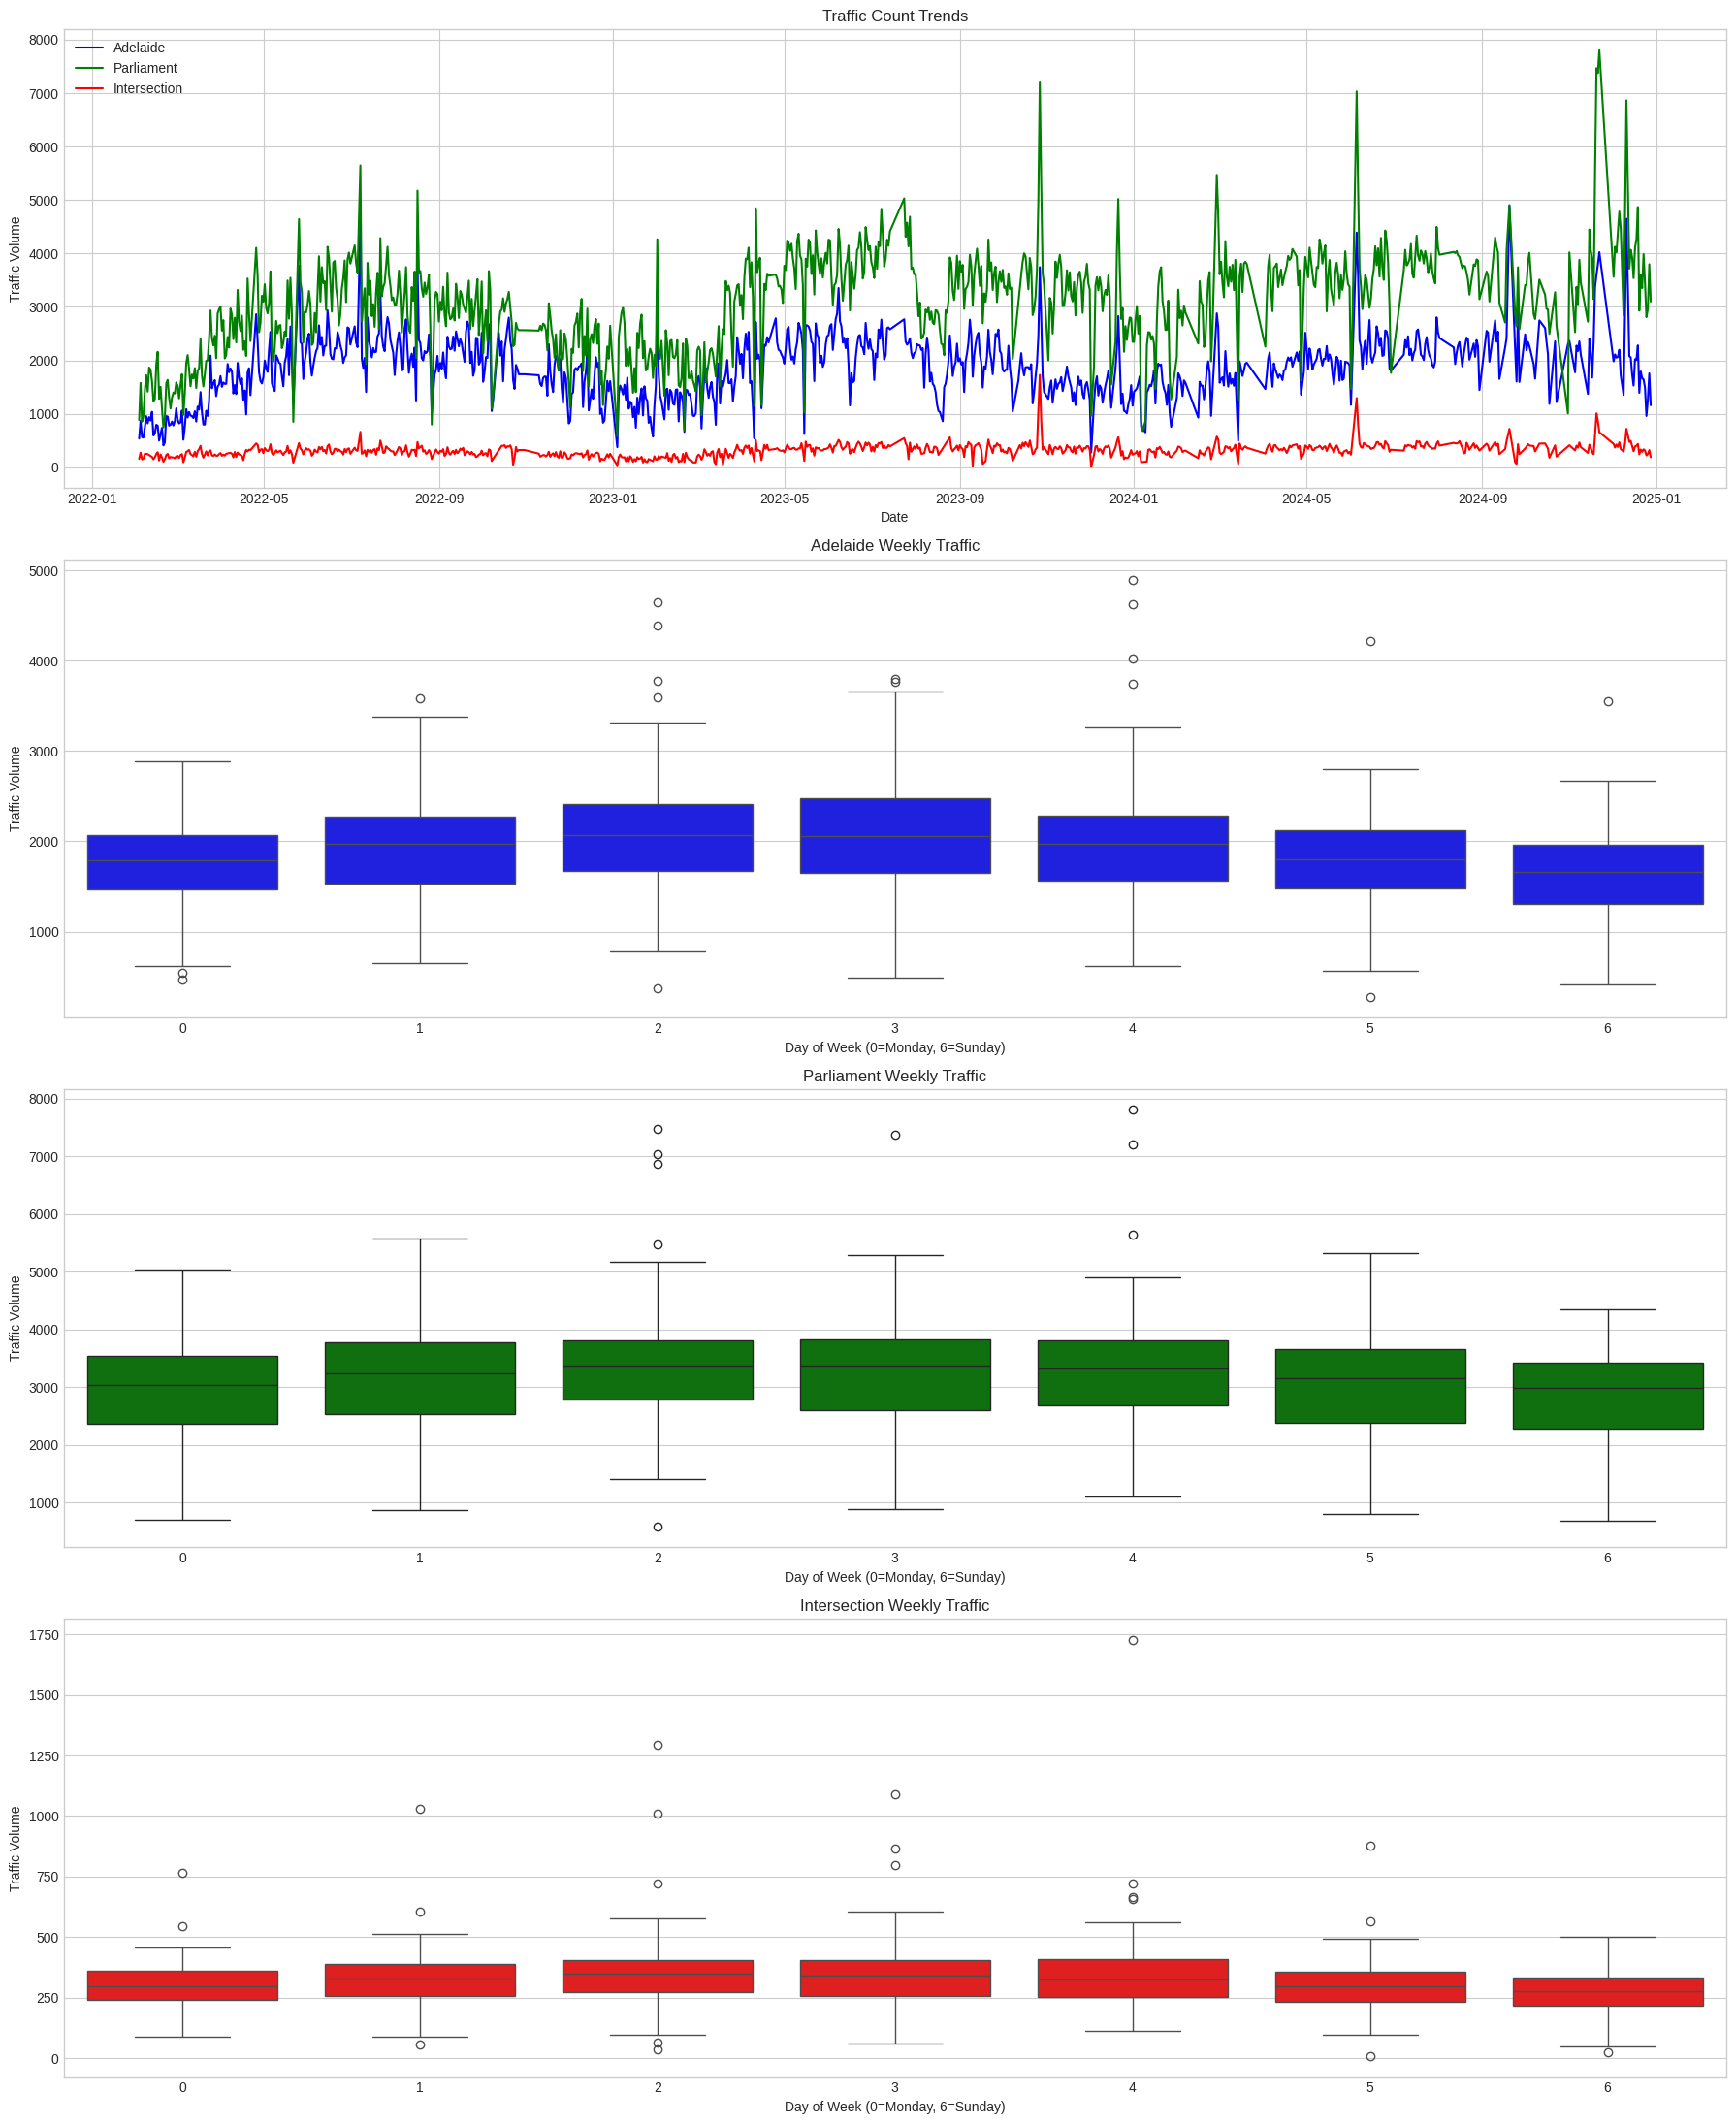

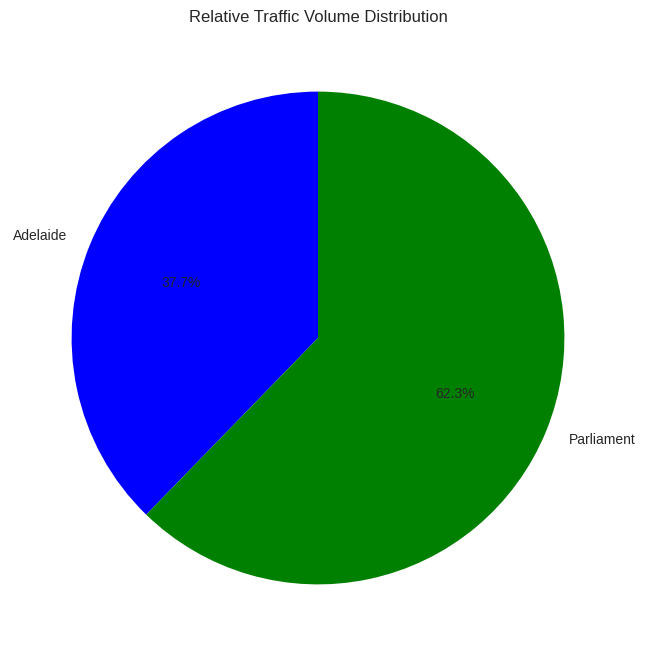

In [121]:
def visualize_traffic_data(street1_data, street2_data, intersection_data, street_names):
    """
    Visualize traffic patterns through multiple plots including:
    - Time series trends
    - Weekly distribution box plots
    - Traffic volume distribution pie chart

    Args:
        street1_data (DataFrame): Processed data for first street
        street2_data (DataFrame): Processed data for second street
        intersection_data (DataFrame): Processed data for intersection
        street_names (dict): Dictionary containing street name identifiers
    """
    # Simple color scheme
    colors = {
        'street1': 'blue',
        'street2': 'green',
        'intersection': 'red'
    }

    # Create figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(18, 22))

    # --------------------------
    # Time Series Plot
    # --------------------------
    axes[0].plot(street1_data.index, street1_data['traffic_count'],
                label=street_names['street1'], color=colors['street1'])
    axes[0].plot(street2_data.index, street2_data['traffic_count'],
                label=street_names['street2'], color=colors['street2'])
    axes[0].plot(intersection_data.index, intersection_data['traffic_count'],
                label='Intersection', color=colors['intersection'])

    axes[0].set_title('Traffic Count Trends')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Traffic Volume')
    axes[0].legend()
    axes[0].grid(True)

    # --------------------------
    # Day of Week Distribution
    # --------------------------
    # Street 1
    sns.boxplot(data=street1_data, x='day_of_week', y='traffic_count',
               ax=axes[1], color=colors['street1'])
    axes[1].set_title(f"{street_names['street1']} Weekly Traffic")
    axes[1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    axes[1].set_ylabel('Traffic Volume')

    # Street 2
    sns.boxplot(data=street2_data, x='day_of_week', y='traffic_count',
               ax=axes[2], color=colors['street2'])
    axes[2].set_title(f"{street_names['street2']} Weekly Traffic")
    axes[2].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    axes[2].set_ylabel('Traffic Volume')

    # Intersection
    sns.boxplot(data=intersection_data, x='day_of_week', y='traffic_count',
               ax=axes[3], color=colors['intersection'])
    axes[3].set_title("Intersection Weekly Traffic")
    axes[3].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    axes[3].set_ylabel('Traffic Volume')

    plt.tight_layout()
    plt.show()

    # --------------------------
    # Traffic Volume Distribution
    # --------------------------
    plt.figure(figsize=(8, 8))
    totals = [
        street1_data['traffic_count'].sum(),
        street2_data['traffic_count'].sum()
    ]

    plt.pie(totals,
           labels=[street_names['street1'], street_names['street2']],
           autopct='%1.1f%%',
           startangle=90,
           colors=[colors['street1'], colors['street2']])
    plt.title('Relative Traffic Volume Distribution')
    plt.show()

# Example usage:
street_names = {
    'street1': 'Adelaide',
    'street2': 'Parliament'
}
visualize_traffic_data(adelaide_data, parliament_data, intersection_data, street_names)

In [122]:
def prepare_ml_features(traffic_data, lag_features=3, include_temporal=True,
                       rolling_features=None, scale_features=False):
    """
    Prepares feature matrix and target vector for traffic prediction models with
    enhanced feature engineering capabilities.

    Parameters:
        traffic_data (pd.DataFrame): DataFrame containing:
            - Required: 'traffic_count' column (target variable)
            - Optional: Temporal features if include_temporal=True
        lag_features (int): Number of lagged traffic features to create (default: 3)
        include_temporal (bool): Whether to include temporal features (default: True)
        rolling_features (dict): Configuration for rolling window features. Format:
            {
                'window_sizes': [3, 7],  # Window sizes to calculate
                'stats': ['mean', 'std']  # Statistics to compute
            }
        scale_features (bool): Whether to scale features (default: False)

    Returns:
        tuple: (X_features, y_target, feature_names) where:
            - X_features: Feature matrix (n_samples, n_features)
            - y_target: Target vector (n_samples,)
            - feature_names: List of feature names

    Example:
        X, y, features = prepare_ml_features(
            traffic_df,
            lag_features=5,
            include_temporal=True,
            rolling_features={
                'window_sizes': [3, 7],
                'stats': ['mean', 'std']
            }
        )
    """
    # Validate input
    if 'traffic_count' not in traffic_data.columns:
        raise ValueError("Input data must contain 'traffic_count' column")

    if lag_features < 1:
        raise ValueError("lag_features must be at least 1")

    # Create working copy
    processed_data = traffic_data.copy()

    # =========================================
    # 1. CORE FEATURE ENGINEERING
    # =========================================
    feature_columns = []

    # Create lag features
    for lag in range(1, lag_features + 1):
        col_name = f'lag_{lag}d'
        processed_data[col_name] = processed_data['traffic_count'].shift(lag)
        feature_columns.append(col_name)

    # Add rolling window features if specified
    if rolling_features:
        window_sizes = rolling_features.get('window_sizes', [3, 7])
        stats = rolling_features.get('stats', ['mean', 'std'])

        for window in window_sizes:
            for stat in stats:
                col_name = f'rolling_{window}d_{stat}'
                if stat == 'mean':
                    processed_data[col_name] = (
                        processed_data['traffic_count']
                        .shift(1)  # Avoid data leakage
                        .rolling(window=window)
                        .mean()
                    )
                elif stat == 'std':
                    processed_data[col_name] = (
                        processed_data['traffic_count']
                        .shift(1)
                        .rolling(window=window)
                        .std()
                    )
                feature_columns.append(col_name)

    # Add temporal features if requested
    if include_temporal:
        temporal_features = []
        for feat in ['day_of_week', 'month', 'day_of_month']:
            if feat in processed_data.columns:
                temporal_features.append(feat)
            else:
                print(f"Warning: Temporal feature '{feat}' not found in data")

        # Add cyclical encoding for periodic features
        if 'day_of_week' in temporal_features:
            processed_data['day_sin'] = np.sin(2 * np.pi * processed_data['day_of_week']/7)
            processed_data['day_cos'] = np.cos(2 * np.pi * processed_data['day_of_week']/7)
            temporal_features.extend(['day_sin', 'day_cos'])

        feature_columns.extend(temporal_features)

    # =========================================
    # 2. DATA CLEANING
    # =========================================
    # Drop rows with NaN values from feature engineering
    processed_data = processed_data.dropna()

    # Validate we have sufficient data
    if len(processed_data) < 10:  # Arbitrary minimum threshold
        raise ValueError("Insufficient data after feature engineering")

    # =========================================
    # 3. FEATURE PROCESSING
    # =========================================
    X = processed_data[feature_columns]
    y = processed_data['traffic_count']

    # Optional feature scaling
    if scale_features:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X),
                         columns=X.columns,
                         index=X.index)

    # Final validation
    if X.isna().any().any() or y.isna().any():
        raise ValueError("NaN values detected in final features/target")

    return X, y, feature_columns

In [123]:
def train_and_evaluate_rf_model(X, y, test_size=0.3, n_estimators=100,
                               random_state=42, time_series_split=False,
                               n_splits=5, plot_results=True):
    """
    Trains and evaluates a Random Forest Regressor model on traffic data with enhanced functionality.

    Parameters:
        X (pd.DataFrame): Feature matrix
        y (pd.Series): Target variable (Traffic count)
        test_size (float): Proportion of data for testing (default: 0.3)
        n_estimators (int): Number of trees in forest (default: 100)
        random_state (int): Random seed for reproducibility (default: 42)
        time_series_split (bool): Whether to use time series split (default: False)
        n_splits (int): Number of splits for time series validation (default: 5)
        plot_results (bool): Whether to plot evaluation visuals (default: True)

    Returns:
        dict: Comprehensive evaluation metrics
        model: Trained RandomForest model
        scaler: Fitted scaler object
        tuple: Scaled data (X_train_scaled, X_test_scaled, y_train, y_test)
        pd.DataFrame: Feature importance dataframe
    """
    # =============================================
    # 1. DATA PREPARATION
    # =============================================
    if time_series_split:
        # Time-series aware splitting
        tscv = TimeSeriesSplit(n_splits=n_splits)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    else:
        # Standard train-test split (no shuffling for time series)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False, random_state=random_state
        )

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # =============================================
    # 2. MODEL TRAINING
    # =============================================
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1,  # Use all available cores
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1
    )

    rf_model.fit(X_train_scaled, y_train)

    # =============================================
    # 3. MODEL EVALUATION
    # =============================================
    y_pred = rf_model.predict(X_test_scaled)

    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'Explained Variance': explained_variance_score(y_test, y_pred)
    }

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    # =============================================
    # 4. VISUALIZATION
    # =============================================
    if plot_results:
        plt.figure(figsize=(15, 10))

        # Actual vs Predicted plot
        plt.subplot(2, 2, 1)
        plt.plot(y_test.index, y_test.values, label='Actual',
                color='#1f77b4', linewidth=1.5, alpha=0.8)
        plt.plot(y_test.index, y_pred, label='Predicted',
                linestyle='--', color='#ff7f0e', linewidth=1.5)
        plt.title('Actual vs Predicted Traffic Count\nRMSE: {:.2f}, R²: {:.2f}'.format(
            metrics['RMSE'], metrics['R2']))
        plt.xlabel('Date')
        plt.ylabel('Traffic Count')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Residual plot
        plt.subplot(2, 2, 2)
        residuals = y_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.6, color='#2ca02c')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residual Analysis')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)

        # Feature importance plot
        plt.subplot(2, 2, 3)
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10),
                    palette='viridis')
        plt.title('Top 10 Feature Importances')
        plt.tight_layout()
        plt.show()

    return {
        'metrics': metrics,
        'model': rf_model,
        'scaler': scaler,
        'data': (X_train_scaled, X_test_scaled, y_train, y_test),
        'feature_importance': feature_importance
    }

In [124]:
def predict_future_periods(model, scaler, X, periods=5, include_confidence=False):
    """
    Predicts future traffic counts using a trained model with autoregressive forecasting.

    Parameters:
        model: Trained machine learning model (must have predict() method)
        scaler: Fitted scaler object (must have transform() method)
        X (pd.DataFrame): Historical feature set with datetime index
        periods (int): Number of future periods to predict (default: 5)
        include_confidence (bool): Whether to return confidence intervals (only works for RandomForest)

    Returns:
        pd.DataFrame: Contains:
            - 'prediction': Predicted traffic counts
            - 'lower_bound': Lower confidence bound (if include_confidence)
            - 'upper_bound': Upper confidence bound (if include_confidence)

    Raises:
        ValueError: If input validation fails
        TypeError: If model doesn't support required methods
    """
    # =============================================
    # 1. INPUT VALIDATION
    # =============================================
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X must be a pandas DataFrame")

    if len(X) < 1:
        raise ValueError("X must contain at least one observation")

    if periods < 1:
        raise ValueError("Periods must be at least 1")

    # Check if model has predict method
    if not hasattr(model, 'predict'):
        raise TypeError("Model must have predict() method")

    # =============================================
    # 2. PREPARE INITIAL STATE
    # =============================================
    # Create working copy of last observation
    last_obs = X.iloc[-1:].copy().astype(float)

    # Validate feature count for autoregressive updates
    n_features = last_obs.shape[1]
    if n_features < 2:
        raise ValueError(f"Need at least 2 features for autoregressive updates, got {n_features}")

    # Initialize storage for predictions and confidence intervals
    predictions = []
    lower_bounds = []
    upper_bounds = []

    # =============================================
    # 3. AUTOREGRESSIVE PREDICTION LOOP
    # =============================================
    for _ in range(periods):
        # Scale features
        last_obs_scaled = scaler.transform(last_obs)

        # Make prediction
        if include_confidence and hasattr(model, 'estimators_'):
            # For RandomForest: get predictions from all trees
            preds = [tree.predict(last_obs_scaled)[0] for tree in model.estimators_]
            point_pred = np.mean(preds)
            std_pred = np.std(preds)

            predictions.append(point_pred)
            lower_bounds.append(point_pred - 1.96 * std_pred)  # 95% CI
            upper_bounds.append(point_pred + 1.96 * std_pred)
        else:
            # Standard prediction
            predictions.append(model.predict(last_obs_scaled)[0])

        # Update features autoregressively
        if n_features > 1:
            # Shift lag features
            last_obs.iloc[0, :-1] = last_obs.iloc[0, 1:].values
            # Update most recent lag with new prediction
            last_obs.iloc[0, -1] = predictions[-1]

    # =============================================
    # 4. FORMAT RESULTS
    # =============================================
    # Create date index for future periods
    freq = pd.infer_freq(X.index) or 'D'  # Default to daily if cannot infer
    future_dates = pd.date_range(
        start=X.index[-1] + pd.Timedelta(1, unit=freq[-1]),
        periods=periods,
        freq=freq
    )

    # Build results DataFrame
    results = pd.DataFrame(
        index=future_dates,
        data={'prediction': predictions}
    )

    if include_confidence and hasattr(model, 'estimators_'):
        results['lower_bound'] = lower_bounds
        results['upper_bound'] = upper_bounds

    return results

In [125]:
def predict_future_periods_for_all(models, scalers, datasets, periods=7, include_confidence=False):
    """
    Predicts future traffic counts for multiple datasets using corresponding models and scalers,
    with enhanced validation and visualization options.

    Parameters:
        models (dict): Dictionary of trained models with keys matching dataset names
            Format: {'dataset_name': model}
        scalers (dict): Dictionary of fitted scalers with keys matching dataset names
            Format: {'dataset_name': scaler}
        datasets (dict): Dictionary of feature DataFrames with datetime index
            Format: {'dataset_name': X_features}
        periods (int): Number of future periods to predict (default: 7)
        include_confidence (bool): Whether to calculate confidence intervals (default: False)

    Returns:
        dict: Dictionary of prediction DataFrames with keys matching input datasets.
            Each DataFrame contains:
            - 'prediction': Predicted values
            - 'lower_bound': Lower confidence bound (if include_confidence=True)
            - 'upper_bound': Upper confidence bound (if include_confidence=True)

    Raises:
        ValueError: If keys don't match across inputs or data validation fails
    """
    # =============================================
    # 1. INPUT VALIDATION
    # =============================================
    if not (set(models.keys()) == set(scalers.keys()) == set(datasets.keys())):
        missing_models = set(datasets.keys()) - set(models.keys())
        missing_scalers = set(datasets.keys()) - set(scalers.keys())
        if missing_models:
            raise ValueError(f"Missing models for datasets: {missing_models}")
        if missing_scalers:
            raise ValueError(f"Missing scalers for datasets: {missing_scalers}")

    if periods < 1:
        raise ValueError("Periods must be at least 1")

    # =============================================
    # 2. PREDICTION GENERATION
    # =============================================
    predictions = {}

    for dataset_name, X in datasets.items():
        try:
            # Get corresponding model and scaler
            model = models[dataset_name]
            scaler = scalers[dataset_name]

            # Generate predictions
            pred_df = predict_future_periods(
                model=model,
                scaler=scaler,
                X=X,
                periods=periods,
                include_confidence=include_confidence
            )

            predictions[dataset_name] = pred_df

        except Exception as e:
            raise ValueError(f"Error predicting for {dataset_name}: {str(e)}") from e

    # =============================================
    # 3. VISUALIZATION
    # =============================================
    if predictions:
        plt.figure(figsize=(15, 8))

        # Define consistent colors for each dataset
        colors = {
            'street1': '#1f77b4',  # Blue
            'street2': '#2ca02c',  # Green
            'Intersection': '#d62728'  # Red
        }

        # Plot predictions for each dataset
        for name, preds in predictions.items():
            color = colors.get(name, '#9467bd')  # Default purple if name not in colors

            # Plot main prediction line
            plt.plot(preds.index, preds['prediction'],
                    label=name, color=color, linewidth=2)

            # Plot confidence interval if available
            if include_confidence and 'lower_bound' in preds.columns:
                plt.fill_between(preds.index,
                               preds['lower_bound'],
                               preds['upper_bound'],
                               color=color, alpha=0.2)

        # Format plot
        plt.title(f'Traffic Predictions for Next {periods} Periods', pad=20)
        plt.xlabel('Date')
        plt.ylabel('Predicted Traffic Count')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Use date locator/formatter for better x-axis
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    return predictions


# Example usage:
# predictions = predict_future_periods_for_all(
#     models={'street1': rf_model1, 'street2': rf_model2, 'Intersection': rf_model_int},
#     scalers={'street1': scaler1, 'street2': scaler2, 'Intersection': scaler_int},
#     datasets={'street1': X_street1, 'street2': X_street2, 'Intersection': X_intersection},
#     periods=14,
#     include_confidence=True
# )

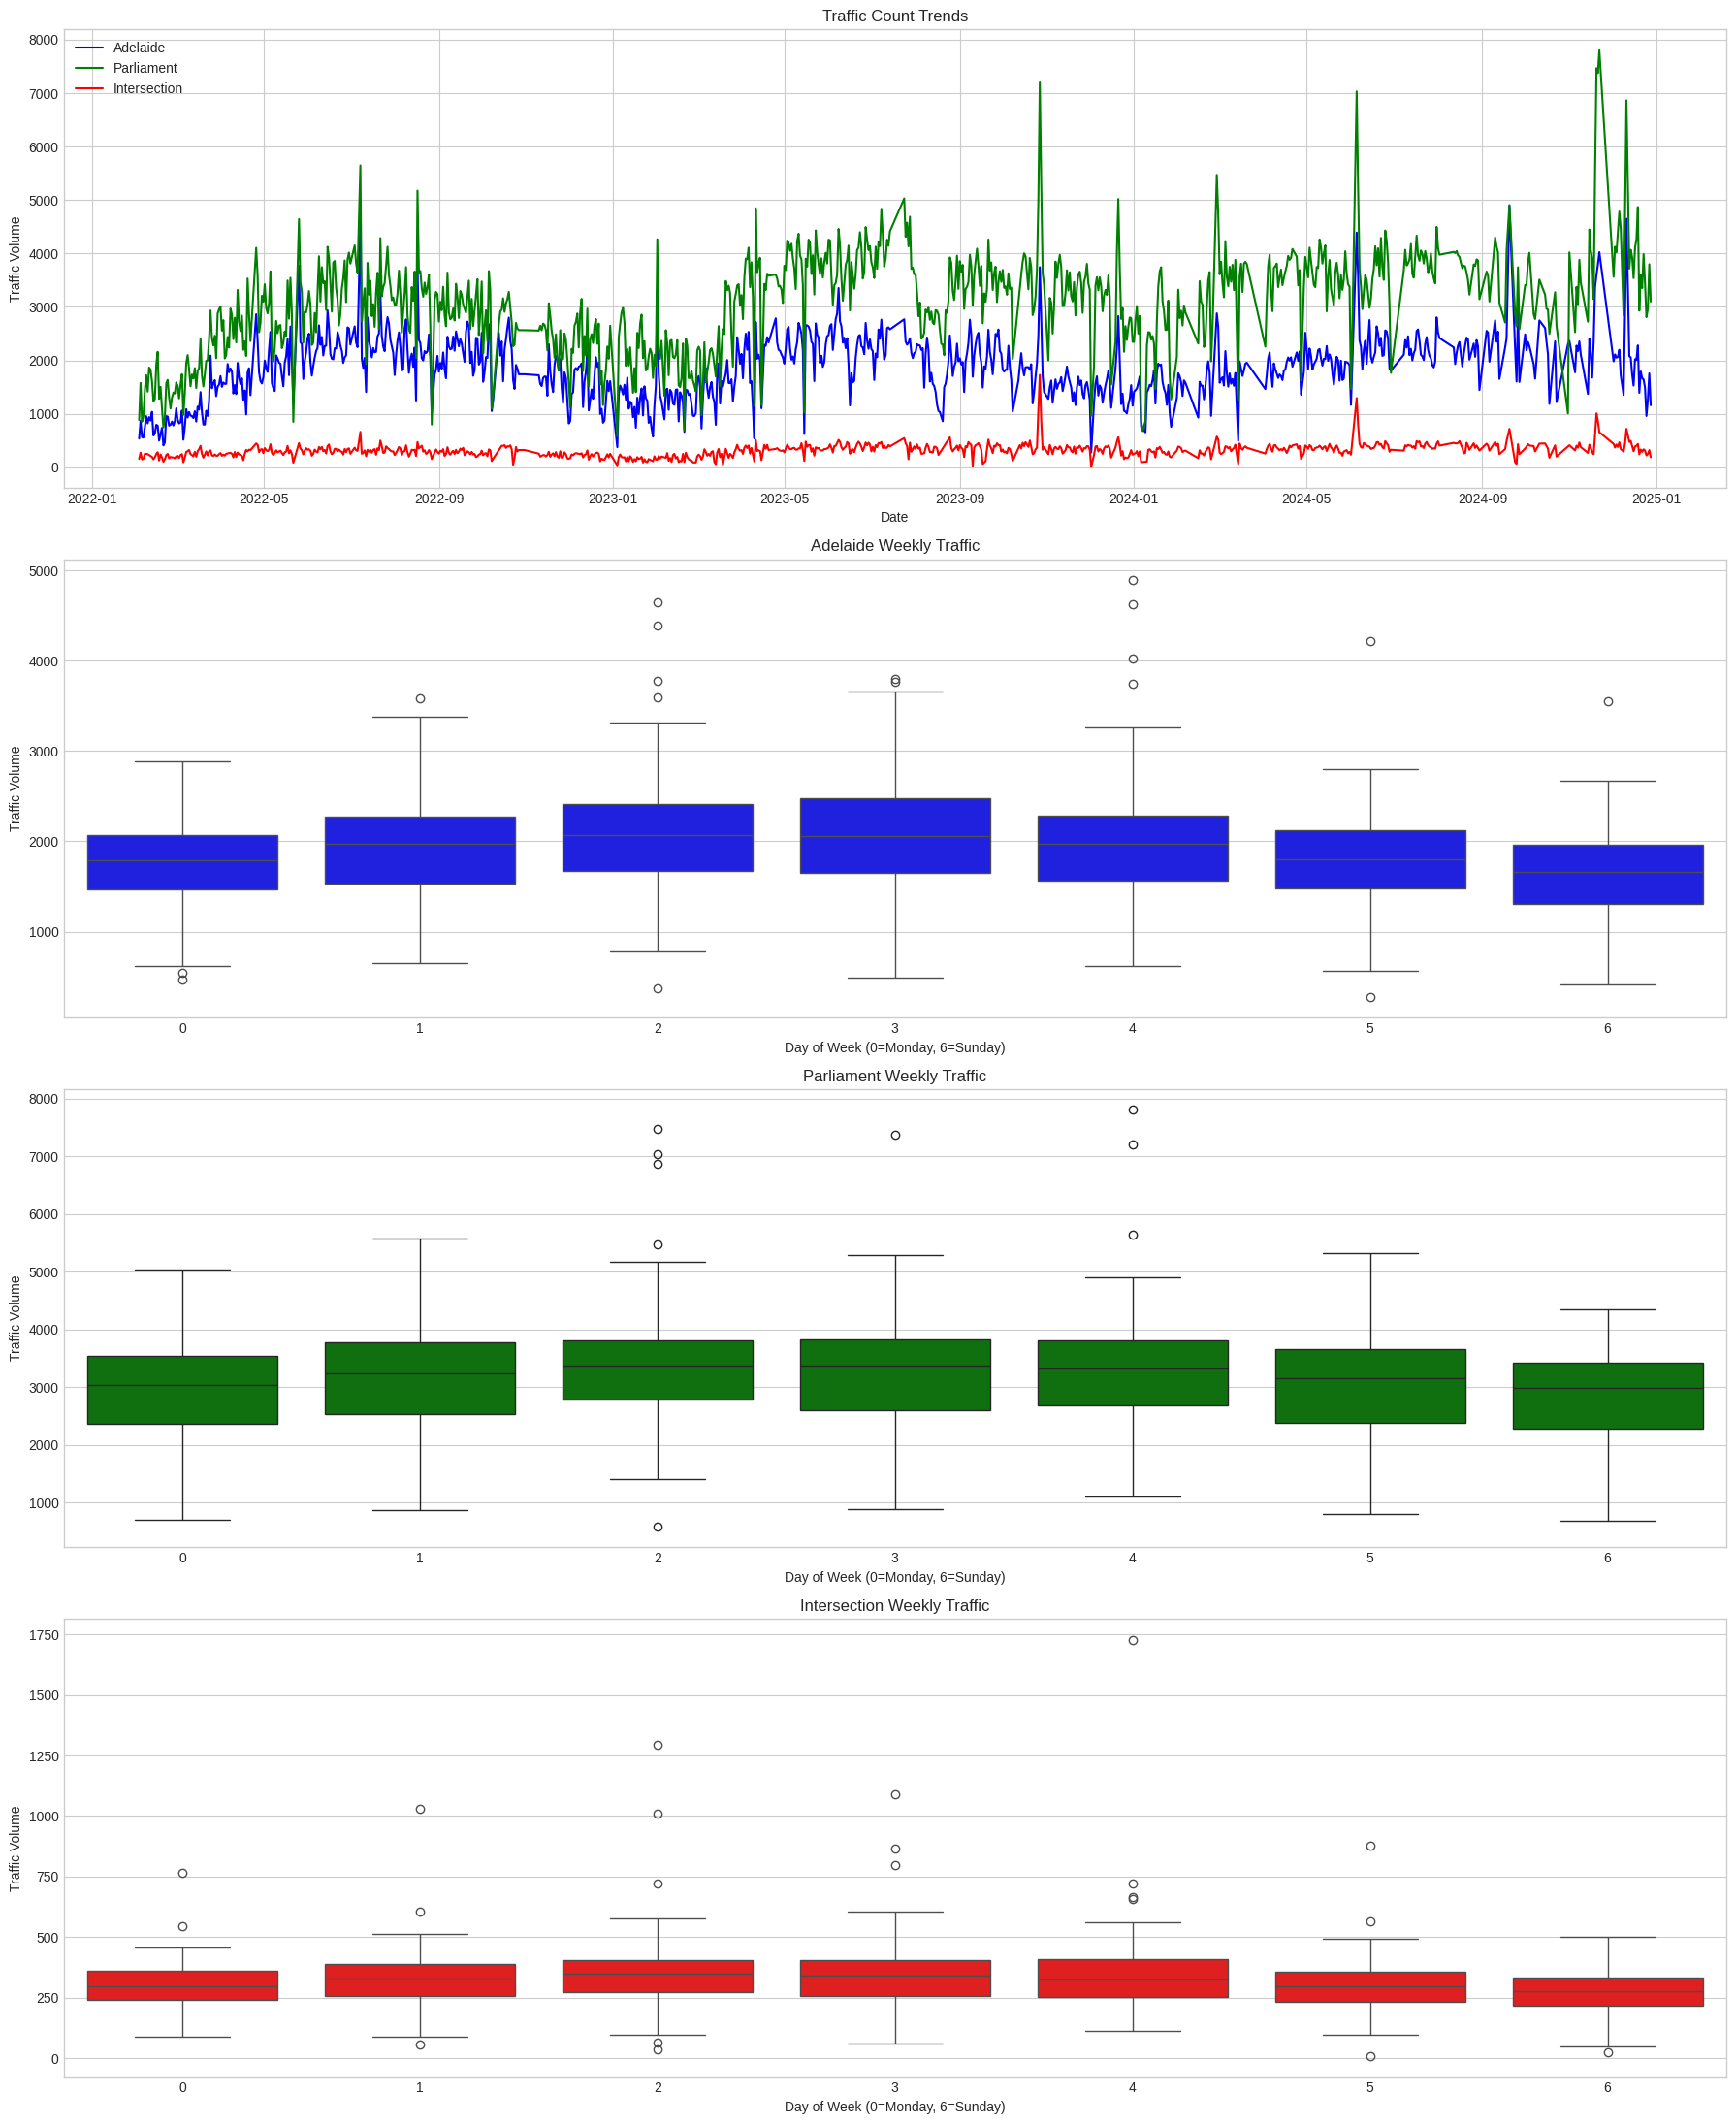

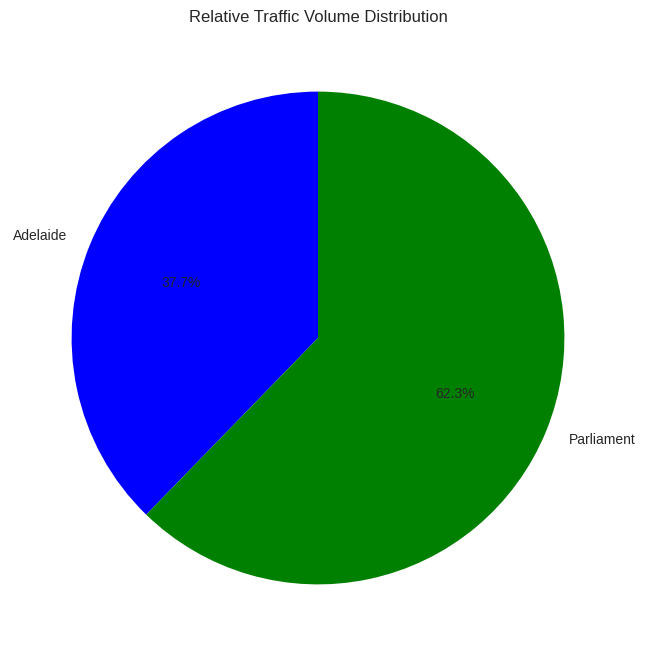

In [126]:
visualize_traffic_data(adelaide_data, parliament_data, intersection_data, street_names)

⏳ Preparing features for all datasets...
✅ Adelaide features prepared (shape: (969, 16))
✅ Parliament features prepared (shape: (969, 16))
✅ Intersection features prepared (shape: (955, 16))

🏋️ Training models for all datasets...

🔍 Processing Adelaide dataset...


<ipython-input-123-9dbf29441243>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10),


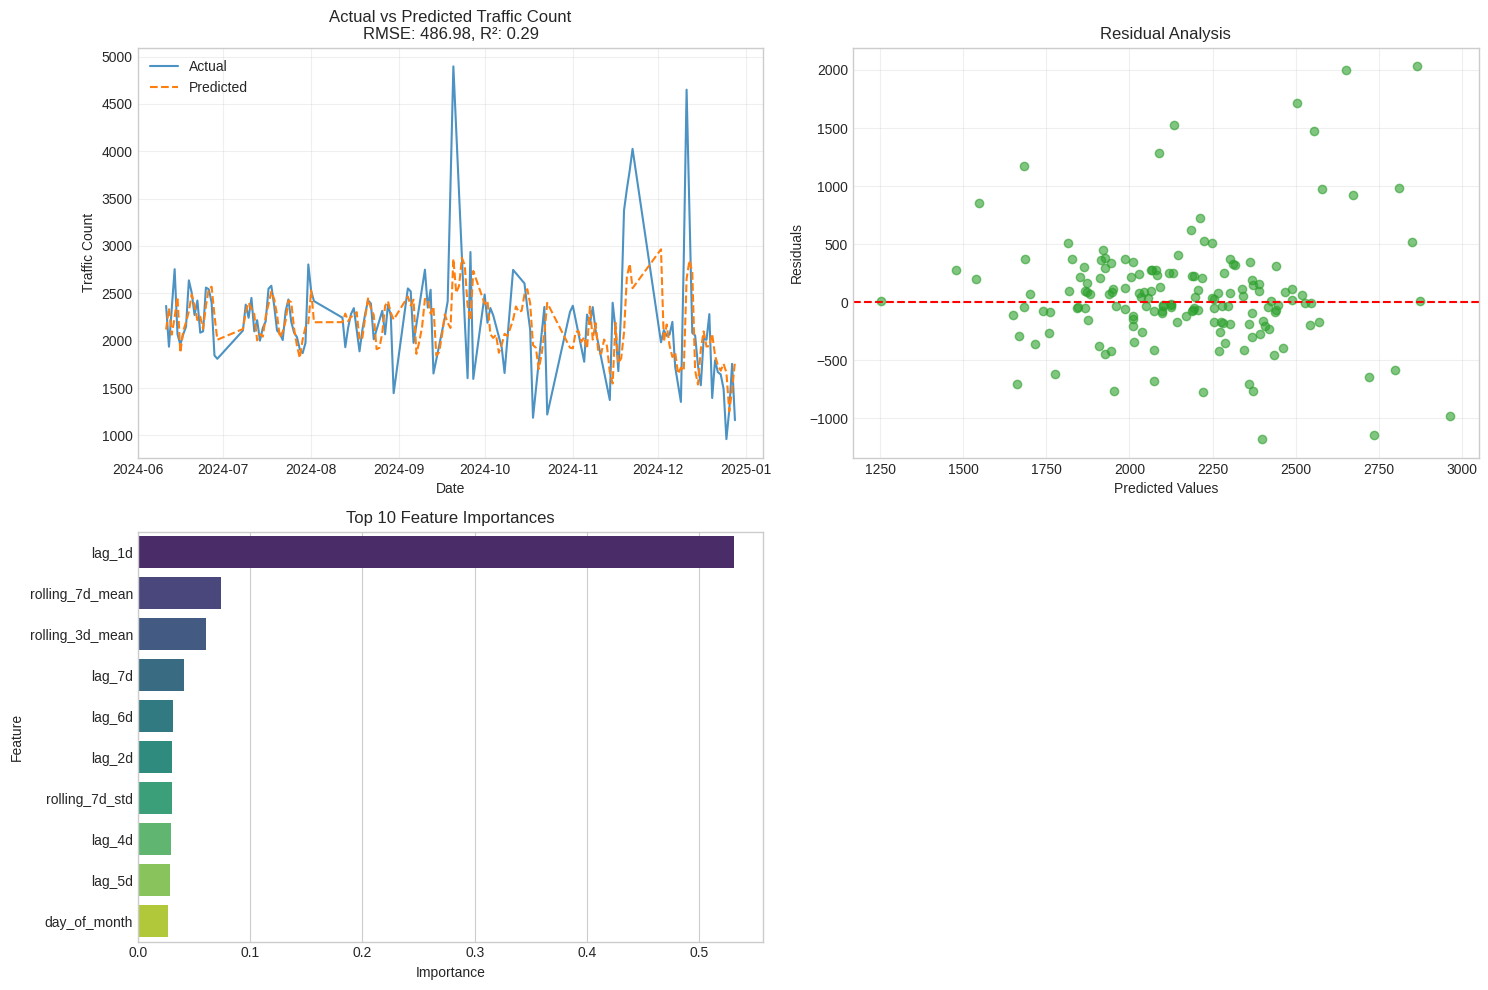

📊 Adelaide Model Performance:
MAE: 315.2700
RMSE: 486.9805
R2: 0.2907
MAPE: 0.1419
Explained Variance: 0.3041

🔍 Processing Parliament dataset...


<ipython-input-123-9dbf29441243>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10),


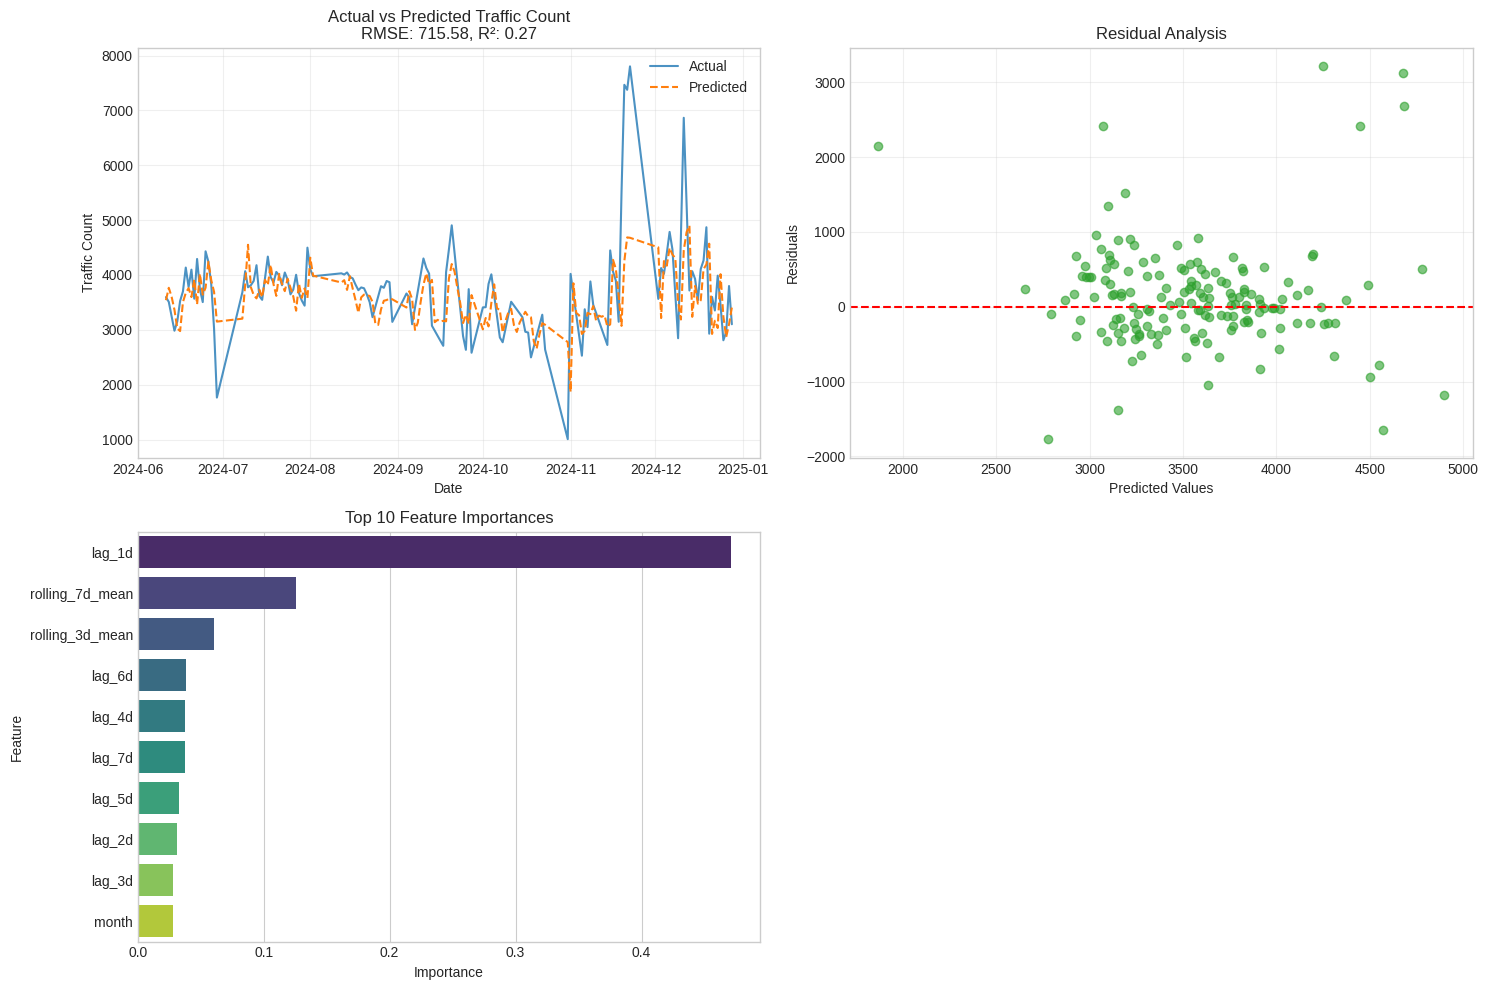

📊 Parliament Model Performance:
MAE: 463.1706
RMSE: 715.5788
R2: 0.2712
MAPE: 0.1280
Explained Variance: 0.2979

🔍 Processing Intersection dataset...


<ipython-input-123-9dbf29441243>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10),


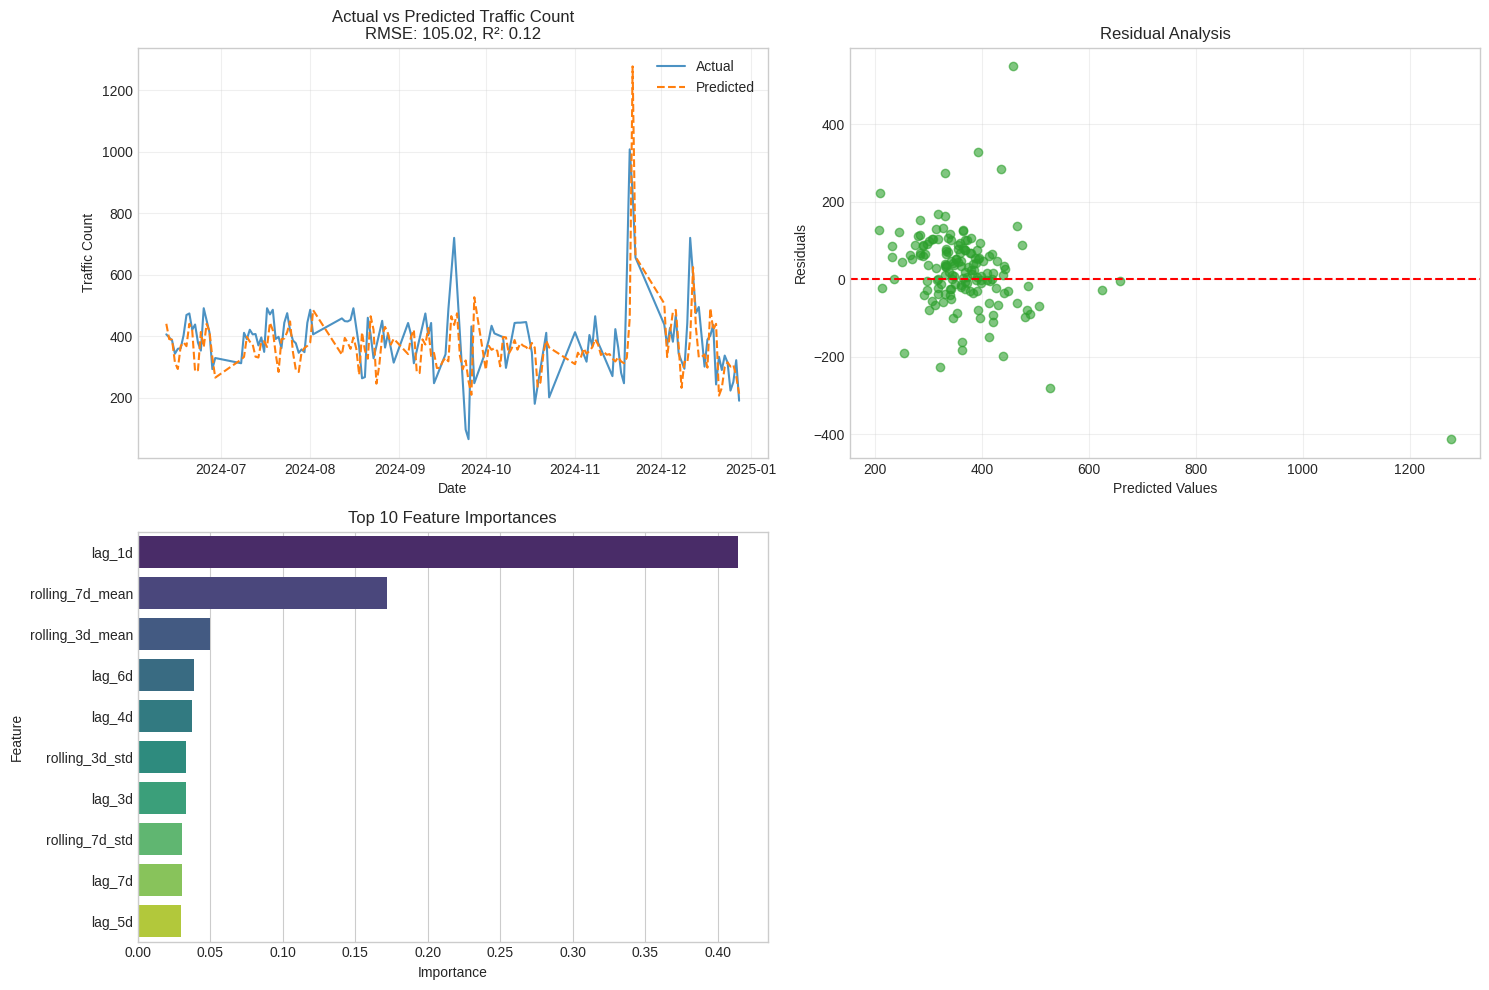

📊 Intersection Model Performance:
MAE: 73.2056
RMSE: 105.0164
R2: 0.1217
MAPE: 0.2111
Explained Variance: 0.1722

🔮 Generating future predictions...


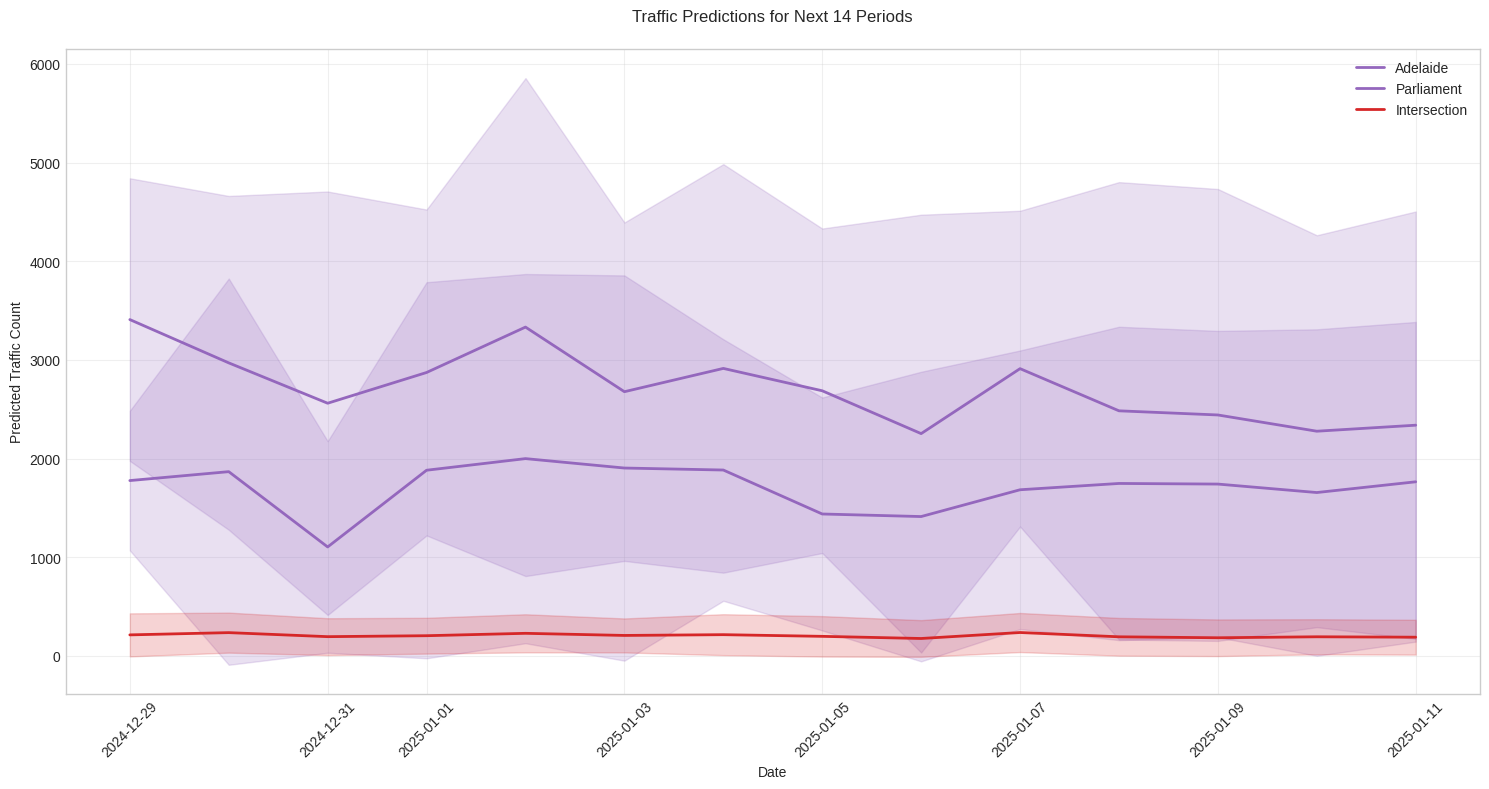


📈 Visualizing results...


<ipython-input-127-4f0ee7cf97fd>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


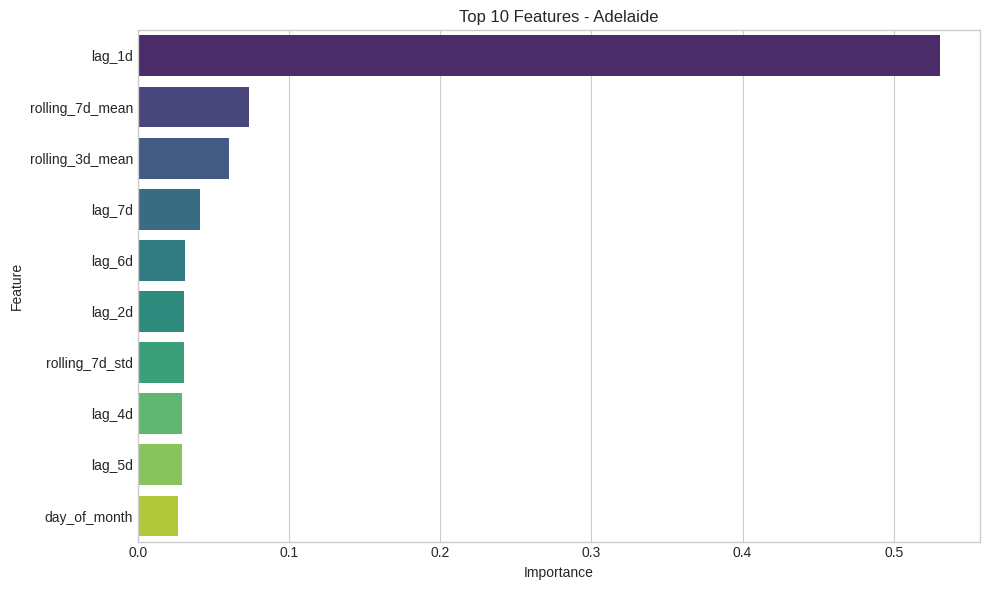

<ipython-input-127-4f0ee7cf97fd>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


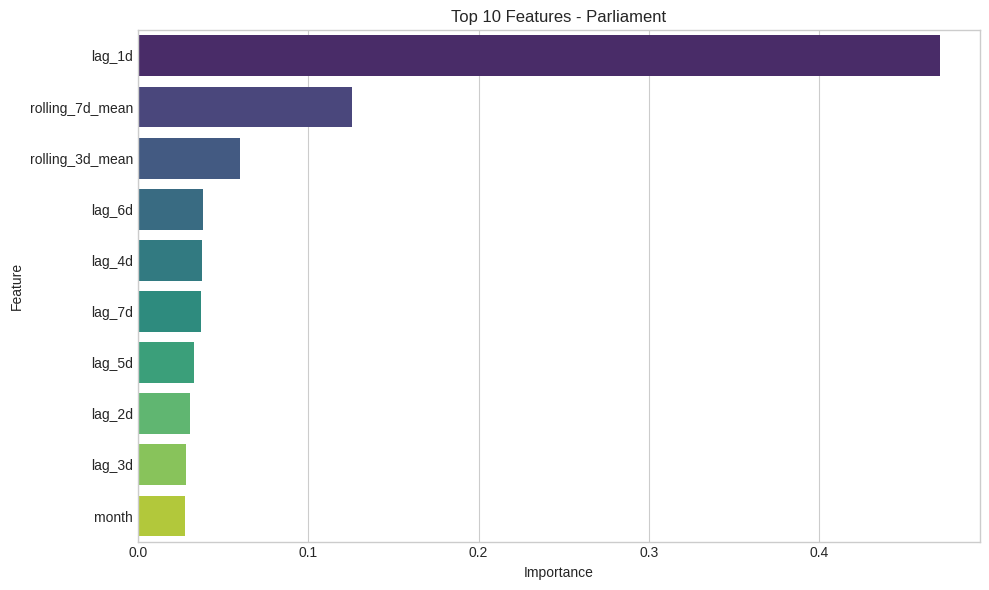

<ipython-input-127-4f0ee7cf97fd>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


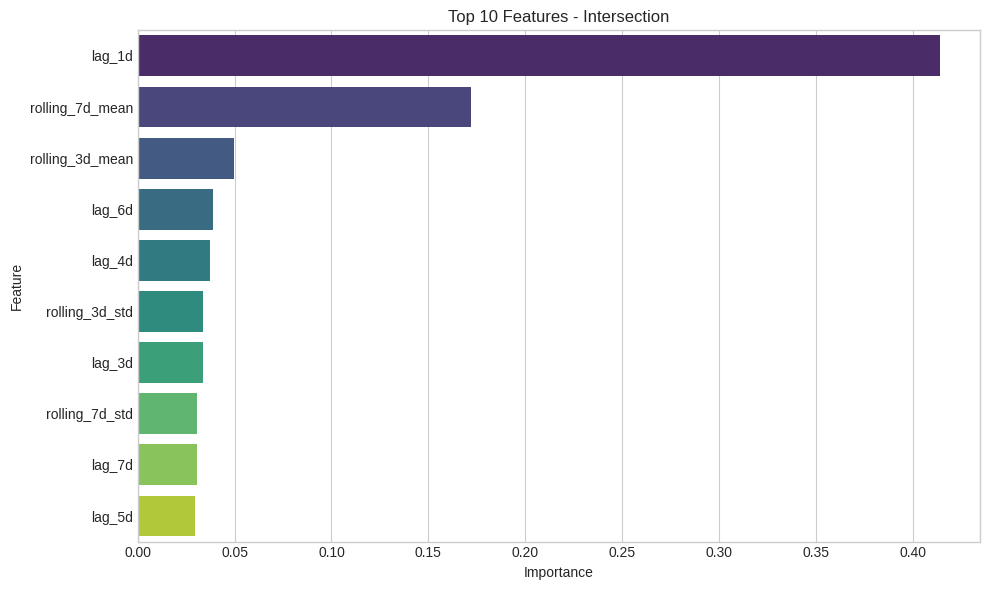


📅 Prediction Summary:

📍 Adelaide - Next 14 periods:
       prediction  lower_bound  upper_bound
count     14.0000      14.0000      14.0000
mean    1703.9921     185.0629    3222.9214
std      239.9426     307.3982     532.9496
min     1103.8100     -90.4744    2176.0352
25%     1662.3288     -18.0530    2933.1721
50%     1755.7750     136.2000    3301.4317
75%     1877.7188     240.3589    3686.3268
max     1999.0650    1068.8991    3870.0655

📍 Parliament - Next 14 periods:
       prediction  lower_bound  upper_bound
count     14.0000      14.0000      14.0000
mean    2723.0096     762.1803    4683.8390
std      364.8222     576.9788     394.6096
min     2252.5000      33.9925    4262.6402
25%     2451.9500     201.7953    4479.1472
50%     2681.9325     825.9452    4592.1963
75%     2912.6525    1175.8989    4783.7831
max     3408.1900    1976.0853    5855.4459

📍 Intersection - Next 14 periods:
       prediction  lower_bound  upper_bound
count     14.0000      14.0000      14.000

In [127]:
def run_traffic_prediction_pipeline(datasets, lag_features=7, prediction_periods=14,
                                  include_confidence=True, random_state=42):
    """
    Complete pipeline for traffic prediction including:
    - Feature preparation
    - Model training
    - Evaluation
    - Future prediction
    - Visualization

    Parameters:
        datasets (dict): Dictionary of traffic DataFrames with keys as dataset names
        lag_features (int): Number of lag features to create (default: 7)
        prediction_periods (int): Number of future periods to predict (default: 14)
        include_confidence (bool): Whether to include confidence intervals (default: True)
        random_state (int): Random seed for reproducibility (default: 42)

    Returns:
        dict: Dictionary containing:
            - 'models': Trained models
            - 'scalers': Feature scalers
            - 'metrics': Evaluation metrics
            - 'predictions': Future predictions
    """
    # =============================================
    # 1. FEATURE PREPARATION
    # =============================================
    prepared_data = {}
    feature_importance = {}

    print("⏳ Preparing features for all datasets...")
    for name, data in datasets.items():
        try:
            X, y, features = prepare_ml_features(
                data,
                lag_features=lag_features,
                include_temporal=True,
                rolling_features={
                    'window_sizes': [3, 7],
                    'stats': ['mean', 'std']
                }
            )
            prepared_data[name] = (X, y)
            print(f"✅ {name} features prepared (shape: {X.shape})")
        except Exception as e:
            print(f"❌ Error preparing features for {name}: {str(e)}")
            continue

    # =============================================
    # 2. MODEL TRAINING & EVALUATION
    # =============================================
    results = {
        'models': {},
        'scalers': {},
        'metrics': {},
        'feature_importance': {}
    }

    print("\n🏋️ Training models for all datasets...")
    for name, (X, y) in prepared_data.items():
        try:
            print(f"\n🔍 Processing {name} dataset...")

            # Train and evaluate model
            model_output = train_and_evaluate_rf_model(
                X, y,
                test_size=0.2,
                n_estimators=200,
                random_state=random_state,
                time_series_split=True
            )

            # Store results
            results['models'][name] = model_output['model']
            results['scalers'][name] = model_output['scaler']
            results['metrics'][name] = model_output['metrics']
            results['feature_importance'][name] = model_output['feature_importance']

            # Print metrics
            print(f"📊 {name} Model Performance:")
            for metric, value in model_output['metrics'].items():
                print(f"{metric}: {value:.4f}")

        except Exception as e:
            print(f"❌ Error training model for {name}: {str(e)}")
            continue

    # =============================================
    # 3. FUTURE PREDICTIONS
    # =============================================
    print("\n🔮 Generating future predictions...")
    results['predictions'] = predict_future_periods_for_all(
        models=results['models'],
        scalers=results['scalers'],
        datasets={name: data[0] for name, data in prepared_data.items()},
        periods=prediction_periods,
        include_confidence=include_confidence
    )

    # =============================================
    # 4. RESULTS VISUALIZATION
    # =============================================
    print("\n📈 Visualizing results...")

    # Plot feature importance for each model
    for name, importance_df in results['feature_importance'].items():
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature',
                   data=importance_df.head(10),
                   palette='viridis')
        plt.title(f'Top 10 Features - {name}')
        plt.tight_layout()
        plt.show()

    # Print prediction summary
    print("\n📅 Prediction Summary:")
    for name, preds in results['predictions'].items():
        print(f"\n📍 {name} - Next {prediction_periods} periods:")
        print(preds.describe())

    return results


# Example usage:
if __name__ == "__main__":
    # Define datasets
    datasets = {
        'Adelaide': adelaide_data,
        'Parliament': parliament_data,
        'Intersection': intersection_data
    }

    # Run complete pipeline
    pipeline_results = run_traffic_prediction_pipeline(
        datasets=datasets,
        lag_features=7,
        prediction_periods=14,
        include_confidence=True,
        random_state=42
    )

    # Access specific results:
    # - pipeline_results['models']  # Trained models
    # - pipeline_results['metrics']  # Evaluation metrics
    # - pipeline_results['predictions']  # Future predictions

## Convolutional Neural Network Implementation

In [128]:
def prepare_cnn_data(X, y, verbose=True):
    """
    Prepares time series data for CNN input by reshaping to 3D format.
    CNN requires 3D input shape: (samples, timesteps, features).

    Parameters:
        X (pd.DataFrame or np.ndarray): Feature matrix of shape (n_samples, n_features)
        y (pd.Series or np.ndarray): Target values of shape (n_samples,)
        verbose (bool): Whether to print shape information (default: True)

    Returns:
        tuple: (X_reshaped, y) where:
            - X_reshaped: 3D numpy array of shape (n_samples, n_features, 1)
            - y: Original target values (unchanged)

    Raises:
        ValueError: If input shapes are incompatible
        TypeError: If input types are invalid
    """
    # Input validation
    if not isinstance(X, (pd.DataFrame, np.ndarray)):
        raise TypeError("X must be pandas DataFrame or numpy array")
    if not isinstance(y, (pd.Series, np.ndarray)):
        raise TypeError("y must be pandas Series or numpy array")
    if len(X) != len(y):
        raise ValueError(f"X and y must have same length. Got X:{len(X)}, y:{len(y)}")

    # Convert to numpy if not already
    if isinstance(X, pd.DataFrame):
        X_values = X.values
    else:
        X_values = X.copy()

    # Reshape to 3D for CNN
    X_reshaped = X_values.reshape(X_values.shape[0], X_values.shape[1], 1)

    if verbose:
        print(f"✅ Data reshaped from {X_values.shape} to {X_reshaped.shape} for CNN")
        print(f"   - Samples: {X_reshaped.shape[0]}")
        print(f"   - Timesteps: {X_reshaped.shape[1]}")
        print(f"   - Channels: {X_reshaped.shape[2]}")

    return X_reshaped, y

In [129]:
def preprocess_data_for_cnn(X, y, test_size=0.2, scaling=True, verbose=True):
    """
    Prepares time series data for CNN by:
    1. Splitting into train/test sets (without shuffling for time series)
    2. Optionally scaling features (MinMax)
    3. Reshaping into 3D format for CNN input

    Parameters:
        X (pd.DataFrame/np.ndarray): Features of shape (n_samples, n_features)
        y (pd.Series/np.ndarray): Targets of shape (n_samples,)
        test_size (float): Proportion for test set (default: 0.2)
        scaling (bool): Whether to scale features (default: True)
        verbose (bool): Whether to print processing details (default: True)

    Returns:
        tuple: (X_train_cnn, X_test_cnn, y_train, y_test, scaler)
            - X_train_cnn: Scaled+reshaped training data (samples, timesteps, channels)
            - X_test_cnn: Scaled+reshaped test data
            - y_train/y_test: Original train/test targets
            - scaler: Fitted scaler object (None if scaling=False)

    Example:
        X_train, X_test, y_train, y_test, scaler = preprocess_data_for_cnn(X, y)
    """
    # Input validation
    if not isinstance(X, (pd.DataFrame, np.ndarray)):
        raise TypeError("X must be DataFrame or ndarray")
    if not isinstance(y, (pd.Series, np.ndarray)):
        raise TypeError("y must be Series or ndarray")
    if len(X) != len(y):
        raise ValueError(f"X and y length mismatch: {len(X)} vs {len(y)}")
    if not 0 < test_size < 1:
        raise ValueError("test_size must be between 0 and 1")

    # Convert to numpy if needed
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.Series) else y

    # Time-series aware split (no shuffling)
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Feature scaling
    scaler = None
    if scaling:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        if verbose:
            print("✅ Features scaled (MinMax)")

    # Reshape for CNN
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    if verbose:
        print(f"\n📊 Final Shapes:")
        print(f"X_train: {X_train_cnn.shape} (samples, timesteps, channels)")
        print(f"X_test: {X_test_cnn.shape}")
        print(f"y_train: {y_train.shape}")
        print(f"y_test: {y_test.shape}\n")

    return X_train_cnn, X_test_cnn, y_train, y_test, scaler

In [130]:
def build_cnn_model(input_shape,
                   filters=[64, 64],
                   kernel_size=2,
                   dense_units=50,
                   dropout_rate=0.2,
                   learning_rate=0.001,
                   metrics=None):
    """
    Builds and compiles a CNN model for time series regression.

    Parameters:
        input_shape (tuple): Shape of input data (timesteps, features)
        filters (list): Number of filters for each Conv1D layer (default: [64, 64])
        kernel_size (int): Size of convolutional kernel (default: 2)
        dense_units (int): Number of units in dense layer (default: 50)
        dropout_rate (float): Dropout rate (default: 0.2)
        learning_rate (float): Learning rate for Adam optimizer (default: 0.001)
        metrics (list): Additional metrics to track (default: ['mae'])

    Returns:
        tf.keras.Model: Compiled CNN model ready for training

    Example:
        model = build_cnn_model(input_shape=(10, 1), filters=[128, 64])
    """
    # Set default metrics
    if metrics is None:
        metrics = ['mae']

    model = Sequential()

    # Input layer with explicit shape
    model.add(Input(shape=input_shape))

    # Add convolutional blocks
    for i, n_filters in enumerate(filters):
        model.add(Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            activation='relu',
            name=f'conv1d_{i}'
        ))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate, name=f'dropout_{i}'))

    # Transition to dense layers
    model.add(Flatten(name='flatten'))

    # Dense layers
    model.add(Dense(
        dense_units,
        activation='relu',
        name='dense_hidden'
    ))

    # Output layer (linear activation for regression)
    model.add(Dense(1, name='output'))

    # Custom Adam optimizer with configurable learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=metrics
    )

    return model

In [131]:
def train_and_evaluate_cnn_model(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn,
                               input_shape, epochs=30, batch_size=16,
                               callbacks=None, verbose=1):
    """
    Trains and evaluates a CNN model for time series prediction with enhanced functionality.

    Parameters:
        X_train_cnn (np.ndarray): 3D training features (samples, timesteps, channels)
        y_train_cnn (np.ndarray): Training targets
        X_test_cnn (np.ndarray): 3D test features
        y_test_cnn (np.ndarray): Test targets
        input_shape (tuple): Shape of input data (timesteps, channels)
        epochs (int): Number of training epochs (default: 30)
        batch_size (int): Batch size (default: 16)
        callbacks (list): List of Keras callbacks (default: None)
        verbose (int): Verbosity mode (0=silent, 1=progress, 2=one line per epoch)

    Returns:
        tuple: (metrics, model, history) where:
            - metrics: Dictionary of evaluation metrics
            - model: Trained CNN model
            - history: Training history object

    Example:
        metrics, model, history = train_and_evaluate_cnn_model(
            X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn,
            input_shape=(10, 1),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=5)]
        )
    """
    # Input validation
    if len(X_train_cnn.shape) != 3:
        raise ValueError("X_train_cnn must be 3D array (samples, timesteps, channels)")
    if len(X_test_cnn.shape) != 3:
        raise ValueError("X_test_cnn must be 3D array")
    if X_train_cnn.shape[1:] != input_shape:
        raise ValueError(f"Input shape mismatch. Expected {input_shape}, got {X_train_cnn.shape[1:]}")

    # Build model with error handling
    try:
        model = build_cnn_model(input_shape)
    except Exception as e:
        raise ValueError(f"Model building failed: {str(e)}") from e

    # Default callbacks if none provided
    if callbacks is None:
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=3
            )
        ]

    # Train model
    history = model.fit(
        X_train_cnn,
        y_train_cnn,
        validation_data=(X_test_cnn, y_test_cnn),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose
    )

    # Evaluate model
    y_pred = model.predict(X_test_cnn).flatten()

    metrics = {
        'MAE': mean_absolute_error(y_test_cnn, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_cnn, y_pred)),
        'R2': r2_score(y_test_cnn, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test_cnn, y_pred)
    }

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return metrics, model, history

In [132]:
def predict_future_periods_for_all(models, scalers, datasets, periods=7, verbose=True):
    """
    Generate future predictions for multiple datasets using trained models with enhanced functionality.

    Parameters:
        models (dict): Dictionary of trained models with keys matching dataset names
        scalers (dict): Dictionary of fitted scalers with keys matching dataset names
        datasets (dict): Dictionary of feature DataFrames with keys matching dataset names
        periods (int): Number of future periods to predict (default: 7)
        verbose (bool): Whether to print progress information (default: True)

    Returns:
        dict: Dictionary of pd.Series containing predictions for each dataset, with:
            - DateTime index starting from day after last observation
            - Predictions in original scale

    Raises:
        ValueError: If keys don't match across inputs or data validation fails
    """
    # =============================================
    # 1. INPUT VALIDATION
    # =============================================
    if not (set(models.keys()) == set(scalers.keys()) == set(datasets.keys())):
        missing_models = set(datasets.keys()) - set(models.keys())
        missing_scalers = set(datasets.keys()) - set(scalers.keys())
        if missing_models:
            raise ValueError(f"Missing models for datasets: {missing_models}")
        if missing_scalers:
            raise ValueError(f"Missing scalers for datasets: {missing_scalers}")

    if periods < 1:
        raise ValueError("Periods must be at least 1")

    # =============================================
    # 2. PREDICTION GENERATION
    # =============================================
    future_predictions = {}

    for name, model in models.items():
        if verbose:
            print(f"\n🔮 Generating predictions for {name}...")

        try:
            # Get corresponding data and scaler
            X_data = datasets[name]
            scaler = scalers[name]

            # Convert to numpy if DataFrame
            if isinstance(X_data, pd.DataFrame):
                X_data = X_data.values

            # Scale the input data
            X_scaled = scaler.transform(X_data)

            # Reshape for CNN (samples, timesteps, features)
            X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

            # Initialize prediction storage
            predictions = []
            current_input = X_cnn[-1].copy()  # Start with last known observation

            for i in range(periods):
                # Reshape for model prediction (1 sample)
                input_reshaped = current_input.reshape(1, *current_input.shape)

                # Make prediction
                pred = model.predict(input_reshaped, verbose=0).flatten()[0]
                predictions.append(pred)

                # Update input by shifting window and adding new prediction
                current_input = np.roll(current_input, -1)
                current_input[-1] = pred

                if verbose:
                    print(f"  Period {i+1}: Predicted = {pred:.2f}")

            # Inverse transform predictions to original scale
            # Create dummy array with same shape as original features
            dummy = np.zeros((len(predictions), X_scaled.shape[1]))
            dummy[:, -1] = predictions  # Assume predictions correspond to last feature

            predictions = scaler.inverse_transform(dummy)[:, -1]

            # Create DateTime index for future periods
            if isinstance(datasets[name], pd.DataFrame):
                last_date = datasets[name].index[-1]
                freq = pd.infer_freq(datasets[name].index) or 'D'  # Default to daily
                dates = pd.date_range(
                    start=last_date + pd.Timedelta(1, unit=freq[-1]),
                    periods=periods,
                    freq=freq
                )
            else:
                dates = pd.date_range(
                    start=pd.Timestamp.now().normalize(),
                    periods=periods,
                    freq='D'
                )

            future_predictions[name] = pd.Series(
                predictions,
                index=dates,
                name=f"{name} Predictions"
            )

        except Exception as e:
            print(f"⚠️ Error predicting for {name}: {str(e)}")
            continue

    # =============================================
    # 3. VISUALIZATION
    # =============================================
    if verbose and future_predictions:
        plt.figure(figsize=(12, 6))

        # Define consistent colors
        colors = plt.cm.tab10(np.linspace(0, 1, len(future_predictions)))

        # Plot predictions for each dataset
        for i, (name, preds) in enumerate(future_predictions.items()):
            plt.plot(
                preds.index,
                preds.values,
                label=name,
                color=colors[i],
                marker='o',
                linestyle='--'
            )

        plt.title(f'Future Traffic Predictions (Next {periods} Periods)')
        plt.xlabel('Date')
        plt.ylabel('Predicted Traffic Count')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Format x-axis dates
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    return future_predictions

In [133]:
def prepare_all_datasets(datasets, lag_features=7, rolling_windows=None, test_size=0.2, random_state=42):
    """
    Prepares feature and target variables for multiple traffic datasets with enhanced feature engineering.

    Parameters:
        datasets (dict): Dictionary of DataFrames with keys as dataset names
        lag_features (int): Number of lag features to create (default: 7)
        rolling_windows (list): Window sizes for rolling statistics (default: [3, 7])
        test_size (float): Proportion for test set if splitting (default: 0.2)
        random_state (int): Random seed for reproducibility (default: 42)

    Returns:
        dict: Dictionary containing prepared data for each dataset with keys:
            - 'train': (X_train, y_train)
            - 'test': (X_test, y_test) if test_size > 0
            - 'full': (X, y) full dataset
            - 'feature_names': List of feature names
    """
    if rolling_windows is None:
        rolling_windows = [3, 7]

    prepared_data = {}

    for name, data in datasets.items():
        try:
            # Feature engineering with rolling statistics
            X, y, feature_names = prepare_ml_features(
                data,
                lag_features=lag_features,
                include_temporal=True,
                rolling_features={
                    'window_sizes': rolling_windows,
                    'stats': ['mean', 'std']
                }
            )

            # Store results
            dataset_dict = {
                'full': (X, y),
                'feature_names': feature_names
            }

            # Optionally split into train/test
            if test_size > 0:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                    test_size=test_size,
                    shuffle=False,  # Important for time series
                    random_state=random_state
                )
                dataset_dict.update({
                    'train': (X_train, y_train),
                    'test': (X_test, y_test)
                })

            prepared_data[name] = dataset_dict
            print(f"✅ Successfully prepared {name} dataset (shape: {X.shape})")

        except Exception as e:
            print(f"❌ Failed to prepare {name} dataset: {str(e)}")
            continue

    return prepared_data

In [134]:
def train_and_evaluate_all_cnn_models(prepared_data, epochs=30, batch_size=16):
    """Main training function that handles all datasets"""
    cnn_models = {}
    cnn_scalers = {}
    cnn_results = {}
    cnn_scaled_data = {}
    cnn_histories = {}  # New dictionary to store training histories

    for name, (X, y) in prepared_data.items():
        print(f"\n{'='*50}")
        print(f"Training CNN model for {name}...")
        print(f"{'='*50}")

        # Preprocess data
        X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, scaler = preprocess_data_for_cnn(X, y)
        input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])

        # Train and evaluate - now unpacking 3 values
        print("\nTraining progress:")
        metrics, model, history = train_and_evaluate_cnn_model(
            X_train_cnn, y_train_cnn,
            X_test_cnn, y_test_cnn,
            input_shape,
            epochs=epochs,
            batch_size=batch_size
        )

        # Store all results
        cnn_models[name] = model
        cnn_scalers[name] = scaler
        cnn_results[name] = metrics
        cnn_scaled_data[name] = (X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn)
        cnn_histories[name] = history  # Store training history

        # Plotting code remains the same
        y_pred = model.predict(X_test_cnn).flatten()
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_cnn.index, y_test_cnn, label='Actual', color='blue', linewidth=2)
        plt.plot(y_test_cnn.index, y_pred, label='Predicted', linestyle='--', color='orange', linewidth=2)
        plt.title(f'Actual vs Predicted Traffic Count - {name}')
        plt.xlabel('Date')
        plt.ylabel('Traffic Count')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"\nEvaluation Metrics for {name}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print("\n" + "="*50)

    return cnn_models, cnn_scalers, cnn_results, cnn_scaled_data, cnn_histories


Training CNN model for Adelaide...
✅ Features scaled (MinMax)

📊 Final Shapes:
X_train: (778, 8, 1) (samples, timesteps, channels)
X_test: (195, 8, 1)
y_train: (778,)
y_test: (195,)


Training progress:
Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3517286.2500 - mae: 1784.5061 - val_loss: 4998487.0000 - val_mae: 2158.1680 - learning_rate: 0.0010
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2950631.7500 - mae: 1612.7921 - val_loss: 1459910.1250 - val_mae: 1062.2605 - learning_rate: 0.0010
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 446323.9062 - mae: 543.2130 - val_loss: 445487.7188 - val_mae: 469.0100 - learning_rate: 0.0010
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 285810.5000 - mae: 421.5209 - val_loss: 431809.0625 - val_mae: 458.7181 - learning_rate: 0.0010
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 289198.6250 - mae: 423.7487 - val_loss: 434525.1250 - val_mae: 461.0230 - learning_rate: 0.0010
Epoch 6/30
49/49 ━

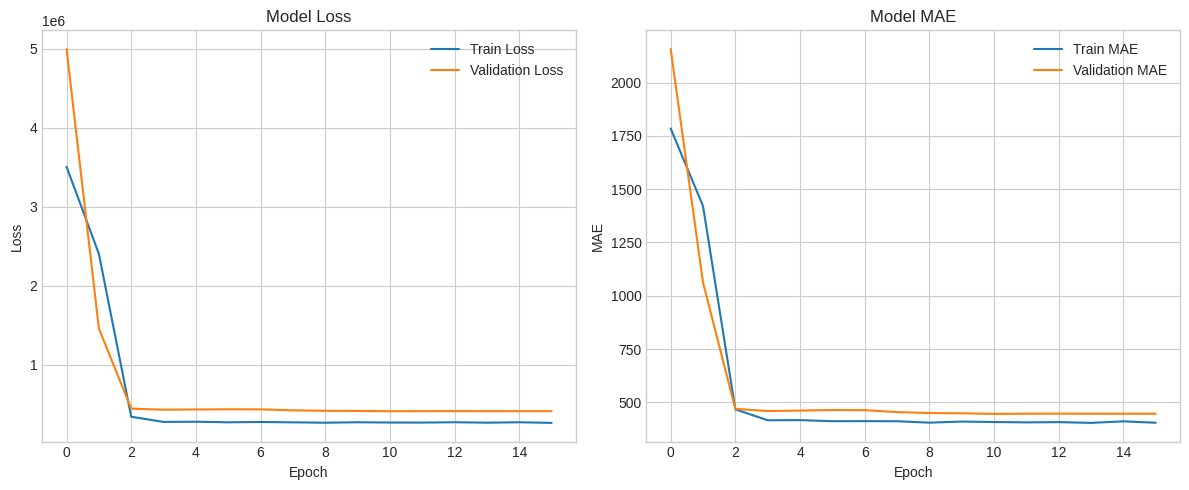

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


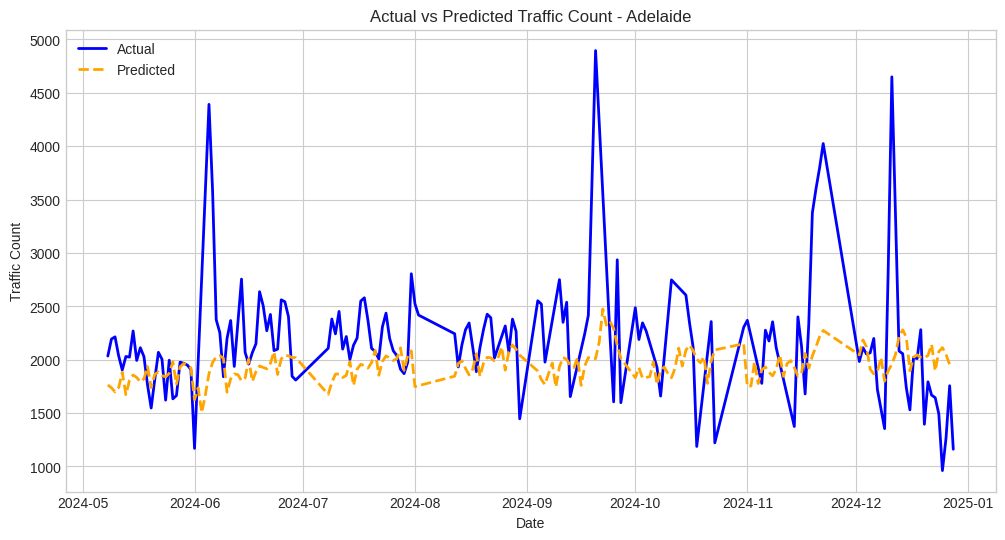


Evaluation Metrics for Adelaide:
MAE: 445.4123
RMSE: 642.0018
R2: -0.2082
MAPE: 0.1905


Training CNN model for Parliament...
✅ Features scaled (MinMax)

📊 Final Shapes:
X_train: (778, 8, 1) (samples, timesteps, channels)
X_test: (195, 8, 1)
y_train: (778,)
y_test: (195,)


Training progress:
Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9530095.0000 - mae: 2950.9329 - val_loss: 14004300.0000 - val_mae: 3645.0505 - learning_rate: 0.0010
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8523910.0000 - mae: 2772.3552 - val_loss: 6734111.0000 - val_mae: 2459.0664 - learning_rate: 0.0010
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2266193.7500 - mae: 1265.8743 - val_loss: 888670.6875 - val_mae: 650.9670 - learning_rate: 0.0010
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 718716.6250 - mae: 666.9725 - val_loss: 1029733.5000 - val_mae: 728.0663 - learning_rate: 0.0010
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 687423.4375 - mae: 

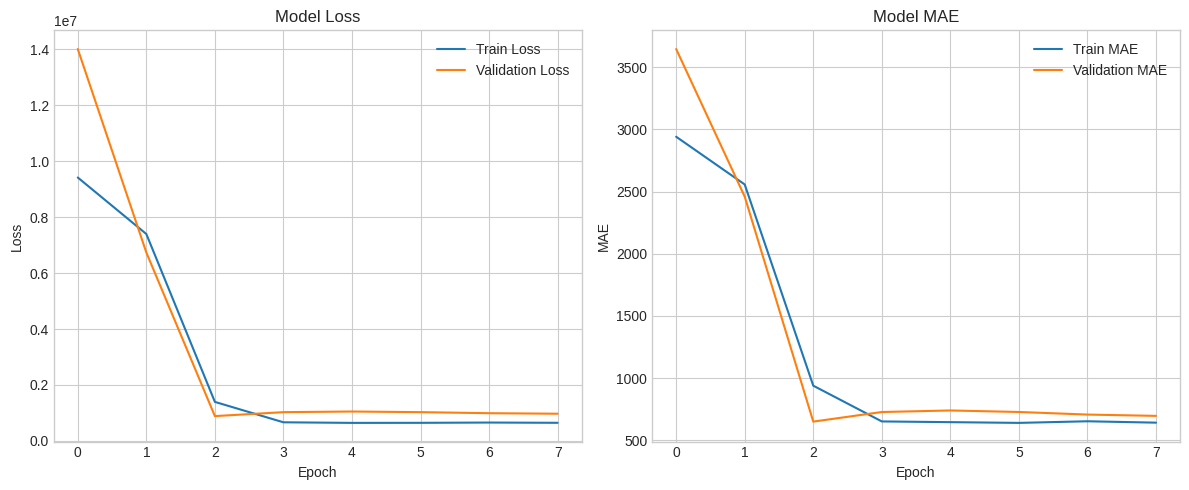

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


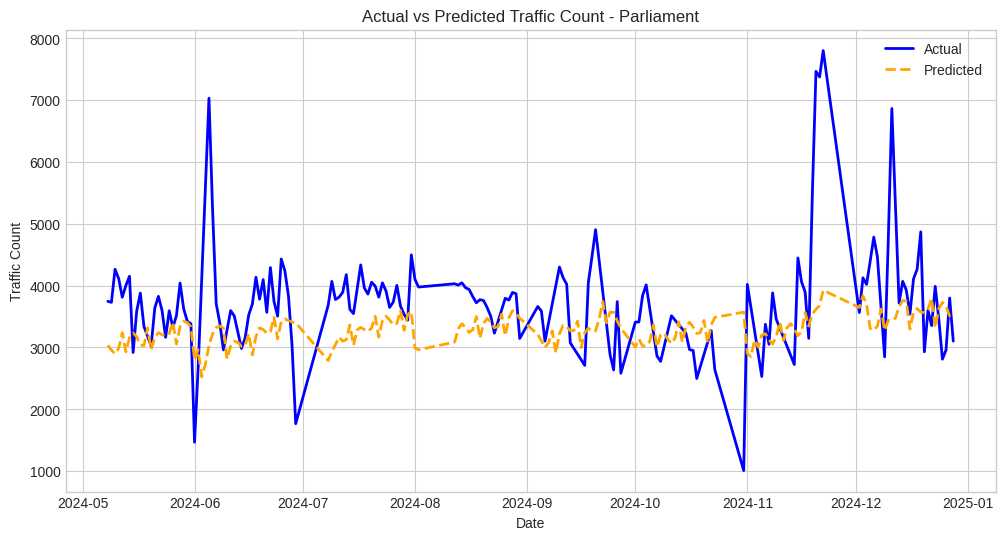


Evaluation Metrics for Parliament:
MAE: 650.9670
RMSE: 942.6933
R2: -0.2359
MAPE: 0.1735


Training CNN model for Intersection...
✅ Features scaled (MinMax)

📊 Final Shapes:
X_train: (767, 8, 1) (samples, timesteps, channels)
X_test: (192, 8, 1)
y_train: (767,)
y_test: (192,)


Training progress:
Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 93177.9688 - mae: 288.4925 - val_loss: 130916.0625 - val_mae: 333.9360 - learning_rate: 0.0010
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 36227.9492 - mae: 160.6793 - val_loss: 25295.6543 - val_mae: 103.3762 - learning_rate: 0.0010
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9674.8574 - mae: 74.6763 - val_loss: 23621.3535 - val_mae: 97.3123 - learning_rate: 0.0010
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9947.0801 - mae: 77.1498 - val_loss: 23296.9043 - val_mae: 96.2366 - learning_rate: 0.0010
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10172.7842 - mae: 77.4958 - val_loss: 2

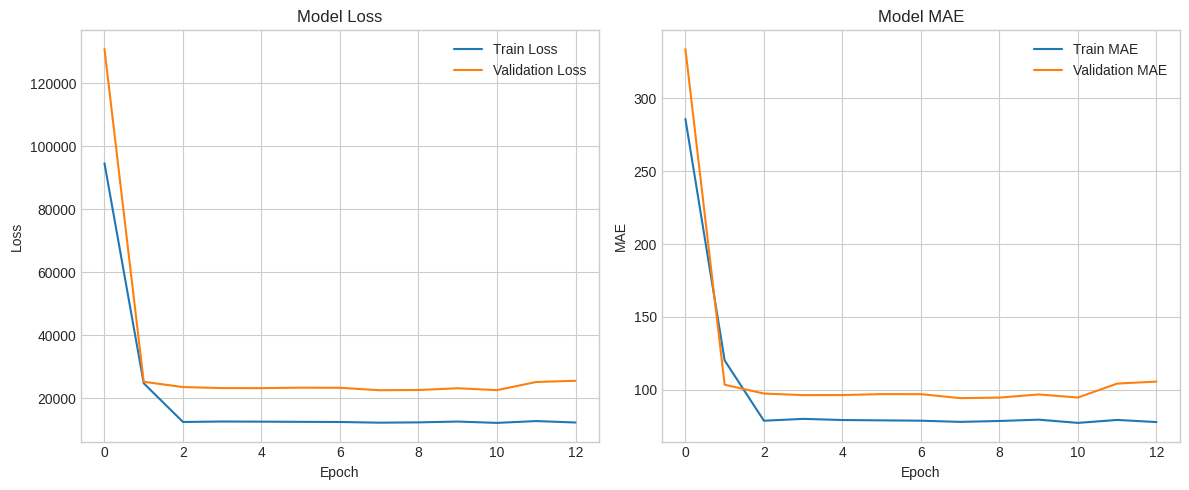

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


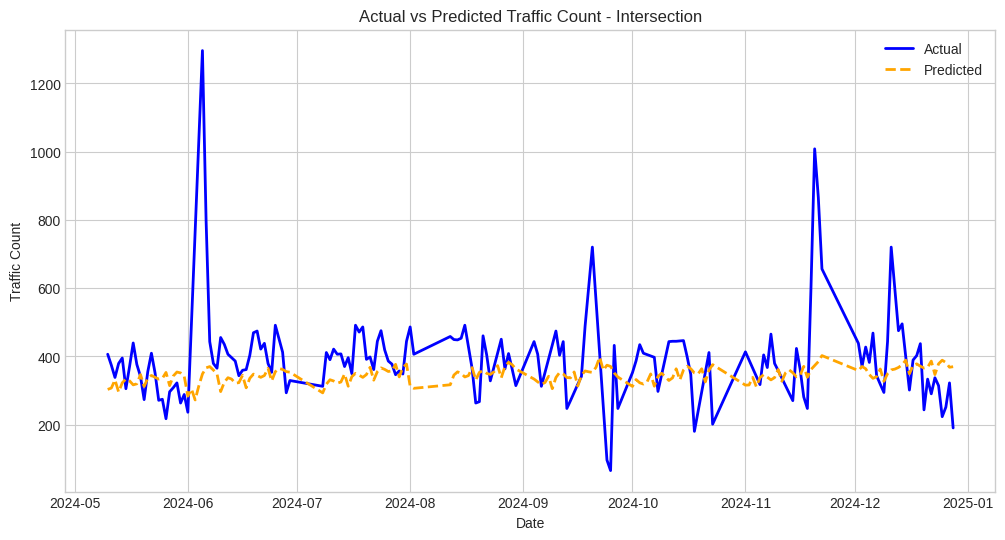


Evaluation Metrics for Intersection:
MAE: 94.1730
RMSE: 150.4001
R2: -0.1711
MAPE: 0.2473



In [135]:
# Initialize result dictionaries
cnn_models = {}
cnn_scalers = {}
cnn_results = {}
cnn_scaled_data = {}

# Process each dataset
for name, (X, y) in prepared_data.items():
    print(f"\n{'='*50}")
    print(f"Training CNN model for {name}...")
    print(f"{'='*50}")

    # Preprocess data - ensuring we keep the original index for y_test
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, scaler = preprocess_data_for_cnn(
        X, y,
        test_size=0.2,
        verbose=True
    )

    # Get the test set indices from the original data
    split_idx = int(len(X) * 0.8)  # Assuming 80% train, 20% test split
    test_indices = X.index[split_idx:]  # Get the datetime indices for the test set

    # Get input shape
    input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])

    # Train and evaluate
    print("\nTraining progress:")
    metrics, model, _ = train_and_evaluate_cnn_model(
        X_train_cnn, y_train_cnn,
        X_test_cnn, y_test_cnn,
        input_shape,
        epochs=30,
        batch_size=16,
        verbose=1
    )

    # Store results
    cnn_models[name] = model
    cnn_scalers[name] = scaler
    cnn_results[name] = metrics
    cnn_scaled_data[name] = (X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn)

    # Plot actual vs predicted - using the saved indices
    y_pred = model.predict(X_test_cnn).flatten()
    plt.figure(figsize=(12, 6))
    plt.plot(test_indices, y_test_cnn, label='Actual', color='blue', linewidth=2)
    plt.plot(test_indices, y_pred, label='Predicted', linestyle='--', color='orange', linewidth=2)
    plt.title(f'Actual vs Predicted Traffic Count - {name}')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print metrics
    print(f"\nEvaluation Metrics for {name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n" + "="*50)

# LSTM


Training LSTM model for Adelaide...
Epoch 1/30
49/49 - 6s - 113ms/step - loss: 3429982.7500 - mae: 1762.7413 - val_loss: 2845081.5000 - val_mae: 1600.5659
Epoch 2/30
49/49 - 1s - 21ms/step - loss: 376670.9688 - mae: 471.8832 - val_loss: 322101.7812 - val_mae: 403.2025
Epoch 3/30
49/49 - 1s - 14ms/step - loss: 207186.5156 - mae: 341.9988 - val_loss: 299628.6875 - val_mae: 386.8739
Epoch 4/30
49/49 - 1s - 18ms/step - loss: 200395.1875 - mae: 336.6781 - val_loss: 290455.4375 - val_mae: 379.9003
Epoch 5/30
49/49 - 1s - 18ms/step - loss: 199168.5938 - mae: 337.5526 - val_loss: 285590.6562 - val_mae: 376.4491
Epoch 6/30
49/49 - 1s - 26ms/step - loss: 199622.5156 - mae: 335.2613 - val_loss: 279109.8750 - val_mae: 370.9696
Epoch 7/30
49/49 - 1s - 21ms/step - loss: 200467.0781 - mae: 337.8097 - val_loss: 275159.5625 - val_mae: 367.6916
Epoch 8/30
49/49 - 1s - 13ms/step - loss: 190042.7500 - mae: 329.4908 - val_loss: 274271.0312 - val_mae: 367.3098
Epoch 9/30
49/49 - 1s - 12ms/step - loss: 1919

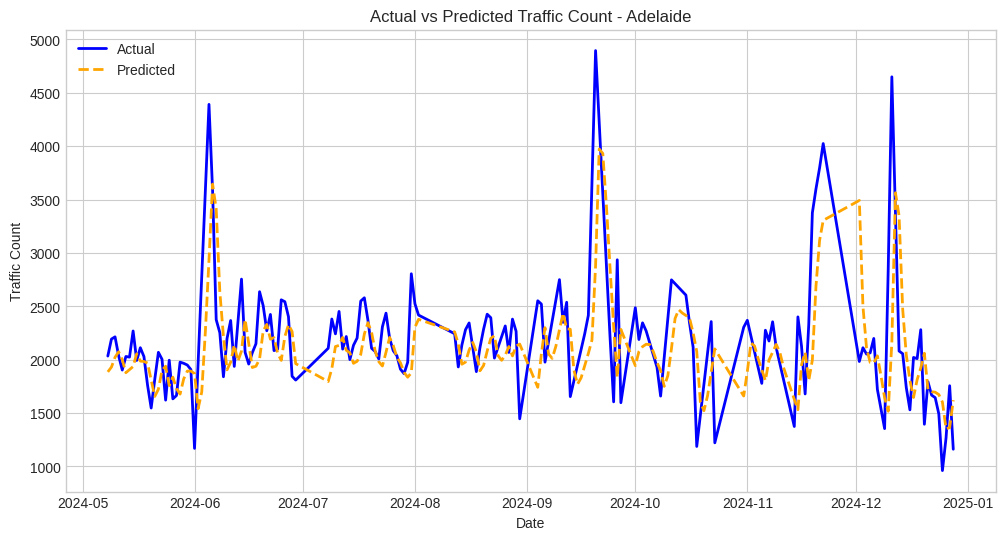


Evaluation Metrics for Adelaide:
MAE: 347.2494
RMSE: 502.8567
R2: 0.2588


Training LSTM model for Parliament...
Epoch 1/30
49/49 - 4s - 92ms/step - loss: 9334633.0000 - mae: 2926.8416 - val_loss: 10926715.0000 - val_mae: 3206.6907
Epoch 2/30
49/49 - 1s - 25ms/step - loss: 1336582.3750 - mae: 868.9611 - val_loss: 814167.8125 - val_mae: 604.0909
Epoch 3/30
49/49 - 1s - 17ms/step - loss: 466927.2500 - mae: 501.5919 - val_loss: 763904.0000 - val_mae: 582.9341
Epoch 4/30
49/49 - 1s - 27ms/step - loss: 453601.1250 - mae: 500.1421 - val_loss: 723341.4375 - val_mae: 564.9708
Epoch 5/30
49/49 - 1s - 16ms/step - loss: 447784.2812 - mae: 494.6700 - val_loss: 702405.0625 - val_mae: 561.1152
Epoch 6/30
49/49 - 1s - 11ms/step - loss: 441124.3125 - mae: 487.9823 - val_loss: 673079.0000 - val_mae: 546.5210
Epoch 7/30
49/49 - 1s - 13ms/step - loss: 442964.4062 - mae: 491.1470 - val_loss: 663504.8750 - val_mae: 542.9176
Epoch 8/30
49/49 - 1s - 12ms/step - loss: 438242.6875 - mae: 487.4632 - val_loss: 

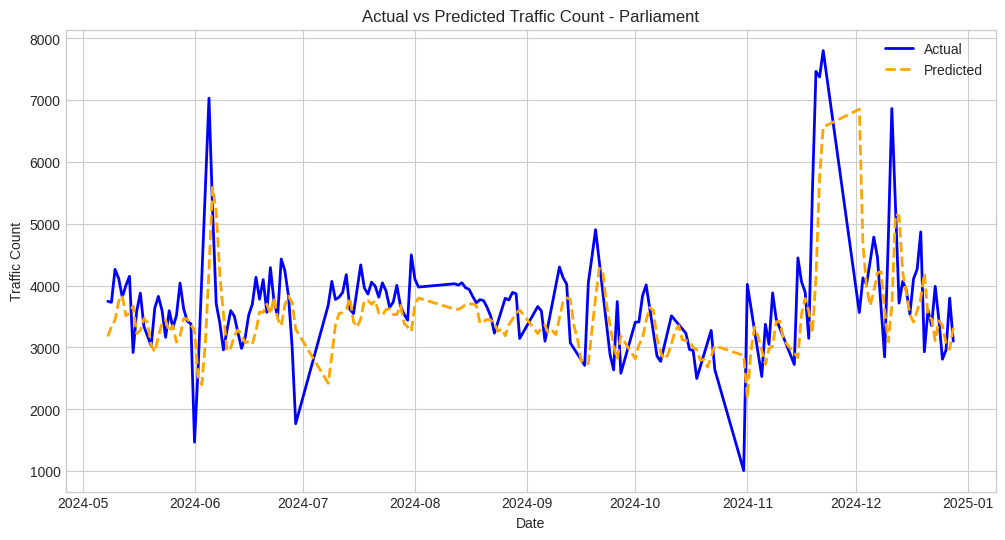


Evaluation Metrics for Parliament:
MAE: 531.9946
RMSE: 795.5793
R2: 0.1197


Training LSTM model for Intersection...
Epoch 1/30
48/48 - 4s - 90ms/step - loss: 91043.6797 - mae: 278.0331 - val_loss: 20081.0918 - val_mae: 95.1525
Epoch 2/30
48/48 - 1s - 19ms/step - loss: 13543.9951 - mae: 82.4215 - val_loss: 18191.1738 - val_mae: 88.4816
Epoch 3/30
48/48 - 1s - 11ms/step - loss: 11528.8516 - mae: 75.9859 - val_loss: 16571.7012 - val_mae: 82.6013
Epoch 4/30
48/48 - 1s - 14ms/step - loss: 11202.2725 - mae: 74.3201 - val_loss: 16524.5605 - val_mae: 82.0407
Epoch 5/30
48/48 - 1s - 28ms/step - loss: 11623.6963 - mae: 75.8976 - val_loss: 16113.7803 - val_mae: 80.4547
Epoch 6/30
48/48 - 1s - 28ms/step - loss: 11311.2363 - mae: 74.3888 - val_loss: 16627.4629 - val_mae: 81.8913
Epoch 7/30
48/48 - 1s - 19ms/step - loss: 11241.8340 - mae: 74.3917 - val_loss: 15926.5459 - val_mae: 79.5366
Epoch 8/30
48/48 - 0s - 10ms/step - loss: 11182.0381 - mae: 74.0424 - val_loss: 16717.4512 - val_mae: 81.9485
E

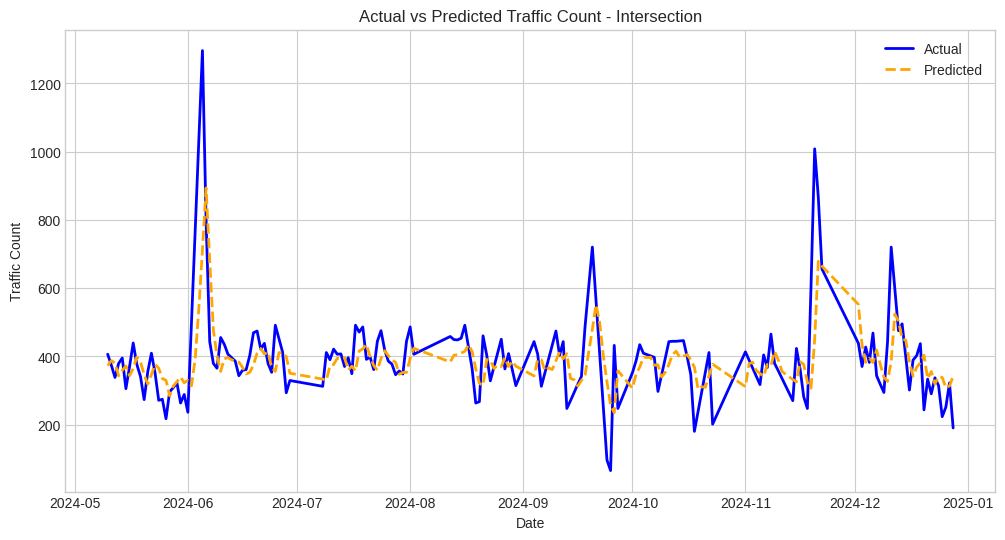


Evaluation Metrics for Intersection:
MAE: 69.5491
RMSE: 110.1167
R2: 0.3722



In [136]:
def train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, input_shape,
                                 epochs=30, batch_size=16, test_indices=None,
                                 dataset_name=""):
    """
    Trains and evaluates LSTM model with dynamic graph titles.
    """
    model = build_lstm_model(input_shape)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    # Plot results with dynamic title
    plt.figure(figsize=(12, 6))
    if test_indices is not None:
        plt.plot(test_indices, y_test, label='Actual', color='blue', linewidth=2)
        plt.plot(test_indices, y_pred, label='Predicted', linestyle='--', color='orange', linewidth=2)
    else:
        plt.plot(y_test, label='Actual', color='blue', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--', color='orange', linewidth=2)

    plt.title(f'Actual vs Predicted Traffic Count - {dataset_name}')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    return metrics, model

# Main training loop with dynamic graph titles
lstm_models = {}
lstm_scalers = {}
lstm_results = {}
lstm_scaled_data = {}

for name, (X, y) in prepared_data.items():
    print(f"\n{'='*50}")
    print(f"Training LSTM model for {name}...")
    print(f"{'='*50}")

    # Preprocess data with index handling
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, scaler, test_indices = preprocess_data_for_lstm(X, y)
    input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

    # Train model with dataset name for title
    metrics, model = train_and_evaluate_lstm_model(
        X_train_lstm, y_train_lstm,
        X_test_lstm, y_test_lstm,
        input_shape,
        test_indices=test_indices,
        dataset_name=name  # Pass dataset name for title
    )

    # Store results
    lstm_models[name] = model
    lstm_scalers[name] = scaler
    lstm_results[name] = metrics
    lstm_scaled_data[name] = (X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm)

    print(f"\nEvaluation Metrics for {name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n" + "="*50)

## Comparing the metrics to determine the best model

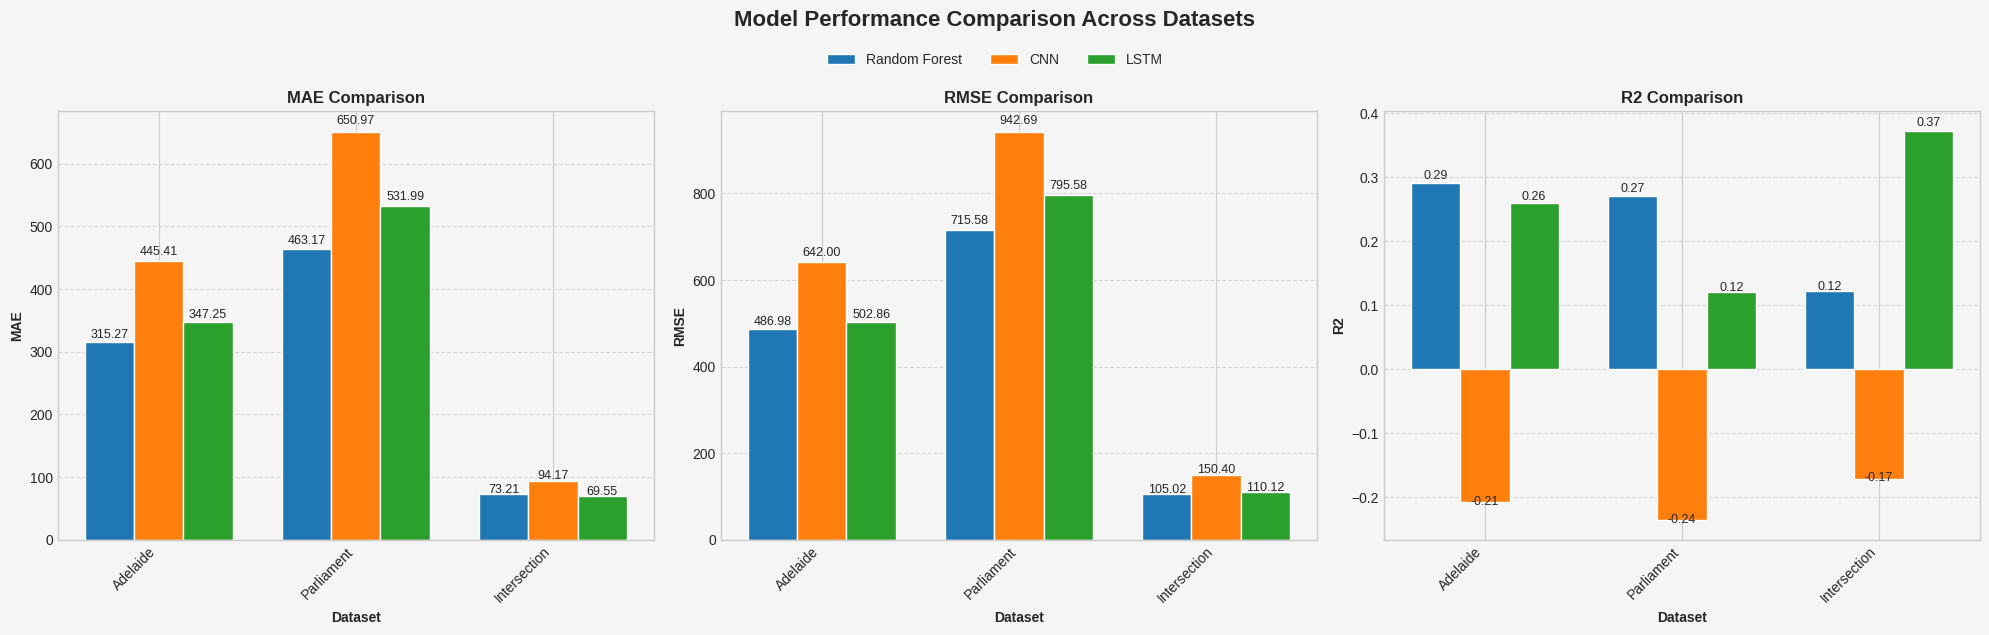


Dataset:                      ADELAIDE                     
Metric         Random Forest       CNN                 LSTM                
---------------------------------------------------------------------------
MAE            315.2700            445.4123            347.2494            
RMSE           486.9805            642.0018            502.8567            
R2             0.2907              -0.2082             0.2588              

Best Model for Each Metric:
MAE: Random Forest
RMSE: Random Forest
R2: Random Forest

Dataset:                     PARLIAMENT                    
Metric         Random Forest       CNN                 LSTM                
---------------------------------------------------------------------------
MAE            463.1706            650.9670            531.9946            
RMSE           715.5788            942.6933            795.5793            
R2             0.2712              -0.2359             0.1197              

Best Model for Each Metric:
MAE

In [137]:
# List of datasets (keys in the dictionaries)
datasets = list(cnn_results.keys())

# Extract metrics for comparison
metrics_names = ['MAE', 'RMSE', 'R2']

# Define a professional color palette
model_colors = {
    'Random Forest': '#1f77b4',  # Blue
    'CNN': '#ff7f0e',            # Orange
    'LSTM': '#2ca02c'            # Green
}

# Prepare data for visualization
fig, axs = plt.subplots(1, 3, figsize=(20, 6), facecolor='#f5f5f5')

# Add overall title
plt.suptitle('Model Performance Comparison Across Datasets',
             fontsize=16, y=1.05, fontweight='bold')

for idx, metric_name in enumerate(metrics_names):
    x = np.arange(len(datasets))  # Dataset indices
    rf_values = [pipeline_results['metrics'][dataset][metric_name] for dataset in datasets]  # Corrected
    cnn_values = [cnn_results[dataset][metric_name] for dataset in datasets]
    lstm_values = [lstm_results[dataset][metric_name] for dataset in datasets]

    # Create bar chart with consistent colors
    axs[idx].bar(x - 0.25, rf_values, 0.25, label='Random Forest',
                color=model_colors['Random Forest'], edgecolor='white')
    axs[idx].bar(x, cnn_values, 0.25, label='CNN',
                color=model_colors['CNN'], edgecolor='white')
    axs[idx].bar(x + 0.25, lstm_values, 0.25, label='LSTM',
                color=model_colors['LSTM'], edgecolor='white')

    # Format each subplot
    axs[idx].set_facecolor('#f5f5f5')
    axs[idx].grid(axis='y', linestyle='--', alpha=0.7)
    axs[idx].set_xlabel('Dataset', fontweight='bold')
    axs[idx].set_ylabel(metric_name, fontweight='bold')
    axs[idx].set_title(f'{metric_name} Comparison', fontweight='bold')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(datasets, rotation=45, ha='right')

    # Add value labels on top of bars
    for i, (rf, cnn, lstm) in enumerate(zip(rf_values, cnn_values, lstm_values)):
        axs[idx].text(i-0.25, rf*1.02, f'{rf:.2f}', ha='center', fontsize=9)
        axs[idx].text(i, cnn*1.02, f'{cnn:.2f}', ha='center', fontsize=9)
        axs[idx].text(i+0.25, lstm*1.02, f'{lstm:.2f}', ha='center', fontsize=9)

# Add legend outside the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Compare metrics for each dataset with improved formatting
for dataset in datasets:
    rf_metrics = pipeline_results['metrics'][dataset]
    cnn_metrics = cnn_results[dataset]
    lstm_metrics = lstm_results[dataset]

    print(f"\n{'='*60}")
    print(f"Dataset: {dataset.upper():^50}")
    print(f"{'='*60}")

    # Print metrics in aligned columns
    print(f"{'Metric':<15}{'Random Forest':<20}{'CNN':<20}{'LSTM':<20}")
    print(f"{'-'*15:<15}{'-'*20:<20}{'-'*20:<20}{'-'*20:<20}")
    for metric in metrics_names:
        print(f"{metric:<15}{rf_metrics[metric]:<20.4f}{cnn_metrics[metric]:<20.4f}{lstm_metrics[metric]:<20.4f}")

    # Determine best models with colored output
    best_mae = min(rf_metrics['MAE'], cnn_metrics['MAE'], lstm_metrics['MAE'])
    best_rmse = min(rf_metrics['RMSE'], cnn_metrics['RMSE'], lstm_metrics['RMSE'])
    best_r2 = max(rf_metrics['R2'], cnn_metrics['R2'], lstm_metrics['R2'])

    print("\nBest Model for Each Metric:")
    print(f"MAE: \033[1;34m{'Random Forest' if best_mae == rf_metrics['MAE'] else 'CNN' if best_mae == cnn_metrics['MAE'] else 'LSTM'}\033[0m")
    print(f"RMSE: \033[1;33m{'Random Forest' if best_rmse == rf_metrics['RMSE'] else 'CNN' if best_rmse == cnn_metrics['RMSE'] else 'LSTM'}\033[0m")
    print(f"R2: \033[1;32m{'Random Forest' if best_r2 == rf_metrics['R2'] else 'CNN' if best_r2 == cnn_metrics['R2'] else 'LSTM'}\033[0m")